<div class="alert alert-block alert-danger">
    <p style="text-align: center;">
        <font size="5">
            <strong>
                Projet n°7 - Implémenter un modèle de scoring
            </strong>
        </font>
    </p>
</div>

<div class="alert alert-block alert-info">
    <p style="text-align: center;">
        <font size="4">
            <strong>
                Notebook exploration <br>             
            </strong>
        </font>
    </p>
</div>

# 1: Import des packages


In [1]:
import numpy as np
import pandas as pd
import gc
import re
import time
import random
import mlflow
import csv
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
import joblib
import sys
import site
import lightgbm

import sklearn.metrics as metrics
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import (
    manifold, decomposition)
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, adjusted_rand_score
)
from sklearn.model_selection import (
    KFold, StratifiedKFold, train_test_split, GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, export_graphviz


from evidently.report import Report

from evidently.metric_preset import DataDriftPreset
from evidently.metrics import *

from evidently.tests import *

warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
mlflow.autolog()

# Exploration et préparation du fichier de données

## Import des données

In [ ]:
# df = pd.read_csv('0_données/application_train.csv')
# test_df = pd.read_csv('0_données/application_test.csv')
# print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
# df = pd.concat([df,test_df]).reset_index()

In [ ]:
# df.shape, test_df.shape

In [ ]:
# pd.concat([df,test_df])

## 1.1 Kernel

In [2]:
# %% [code]
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)



@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


In [3]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('0_données/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('0_données/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df,test_df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('0_données/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('0_données/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('0_données/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('0_données/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('0_données/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('0_données/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    # Divide in training/validation and test data
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    df = df.rename(columns = lambda x:x.upper())
    for i in df.columns:
        if df[i].dtypes=='object':
            df[i]=df[i].astype('bool')
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc')

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv('1_outputs/output_kfolds', index= False)
        feature_importance_df.to_csv('1_outputs/feature_importance',index=False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('1_outputs/lgbm_importances01.png')


def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

## débug du kernel

In [ ]:
# temp=main_temp(debug=True)

In [ ]:
# temp.loc[:,temp.dtypes.values=='object']

In [ ]:
# for i in temp.columns:
#     if temp[i].dtypes=='object':
#         temp[i]=temp[i].astype('bool')

In [ ]:
# temp.dtypes.value_counts()

In [ ]:
# temp['CC_NAME_CONTRACT_STATUS_Active_MIN'].dtypes

In [ ]:
# kfold_lightgbm(temp, 2, stratified = False, debug= True)

In [ ]:
# def main(debug = True):
#     num_rows = 10000 if debug else None
#     df = application_train_test(num_rows)
#     with timer("Process bureau and bureau_balance"):
#         bureau = bureau_and_balance(num_rows)
#         print("Bureau df shape:", bureau.shape)
#         df = df.join(bureau, how='left', on='SK_ID_CURR')
#         del bureau
#         gc.collect()
#     with timer("Process previous_applications"):
#         prev = previous_applications(num_rows)
#         print("Previous applications df shape:", prev.shape)
#         df = df.join(prev, how='left', on='SK_ID_CURR')
#         del prev
#         gc.collect()
#     with timer("Process POS-CASH balance"):
#         pos = pos_cash(num_rows)
#         print("Pos-cash balance df shape:", pos.shape)
#         df = df.join(pos, how='left', on='SK_ID_CURR')
#         del pos
#         gc.collect()
#     with timer("Process installments payments"):
#         ins = installments_payments(num_rows)
#         print("Installments payments df shape:", ins.shape)
#         df = df.join(ins, how='left', on='SK_ID_CURR')
#         del ins
#         gc.collect()
#     with timer("Process credit card balance"):
#         cc = credit_card_balance(num_rows)
#         print("Credit card balance df shape:", cc.shape)
#         df = df.join(cc, how='left', on='SK_ID_CURR')
#         del cc
#         gc.collect()
#     with timer("Run LightGBM with kfold"):
#         feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug=True)

In [ ]:
# dict1={'CC_NAME_CONTRACT_STATUS_Active_MIN': object, 'CC_NAME_CONTRACT_STATUS_Active_MAX': object,
# ' CC_NAME_CONTRACT_STATUS_Approved_MIN': object, 'CC_NAME_CONTRACT_STATUS_Approved_MAX': object, 'CC_NAME_CONTRACT_STATUS_Completed_MIN': object,
#  'CC_NAME_CONTRACT_STATUS_Completed_MAX': object, 'CC_NAME_CONTRACT_STATUS_Demand_MIN': object, 'CC_NAME_CONTRACT_STATUS_Demand_MAX': object,
#   'CC_NAME_CONTRACT_STATUS_Refused_MIN': object, 'CC_NAME_CONTRACT_STATUS_Refused_MAX': object, 'CC_NAME_CONTRACT_STATUS_Sent proposal_MIN': object,
#    'CC_NAME_CONTRACT_STATUS_Sent proposal_MAX': object, 'CC_NAME_CONTRACT_STATUS_Signed_MIN': object, 'CC_NAME_CONTRACT_STATUS_Signed_MAX': object,
#     'CC_NAME_CONTRACT_STATUS_nan_MIN': object, 'CC_NAME_CONTRACT_STATUS_nan_MAX': object}

In [ ]:
# dict1.values(),dict1.keys()

In [ ]:
# application_train_test(5000)

In [ ]:

# def has_special_characters(s):
#     # Define a regular expression pattern to match JSON special characters
#     special_char_pattern = re.compile(r'["\\/\\b\\f\\n\\r\\t]')
    
#     # Search for special characters in the string
#     return bool(special_char_pattern.search(s)),special_char_pattern.search(s)

# # Check each string for special characters
# for s in temp.columns:
#     if has_special_characters(s)[0]:
#         print(f"'{s}' contains JSON special characters.",has_special_characters(s))
    

In [ ]:
# feats.index('NAME_CONTRACT_TYPE_Cash_loans')

In [ ]:
# feats[107][27]

In [ ]:
# temp = temp.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [ ]:
# # Check each string for special characters
# for s in temp.columns:
#     if has_special_characters(s)[0]:
#         print(f"'{s}' contains JSON special characters.",has_special_characters(s))

In [ ]:
# temp = temp.rename(columns = lambda x:x.upper())

In [ ]:
# temp.head()

In [ ]:
# # Check each string for special characters
# for s in temp.columns:
#     if has_special_characters(s)[0]:
#         print(f"'{s}' contains JSON special characters.",has_special_characters(s))

Solution stackoverflow:  
rename les colonnes avec df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))


In [ ]:
# Liste des erreurs/ modifs par rapport au kernal de base:
# modif des chemins d'import
# Append => concat dans application test_train
# enlever verbose dans le clf.fit
# enlever early_stopping_rounds
# ajouter le force des types
# ajouter import re
# ajouter fonctions de rename des colonnes pour retirer les caractères json et forcer en upper pour que lightgbm fonctionne correctement

## Reprise des traitements

In [ ]:
# # 15 min30 pour fold =2
# kfold_lightgbm(application_train_test(), 2, stratified = False)

In [ ]:
#50 min avec 2 folds, 4h+ avec 10 folds
#main()

Sauvegarde du print de sortie avec 2 folds <br>
Train samples: 307511, test samples: 48744  <br>
Bureau df shape: (305811, 116)  <br>
Process bureau and bureau_balance - done in 28s <br>
Previous applications df shape: (338857, 249) <br>
Process previous_applications - done in 40s <br>
Pos-cash balance df shape: (337252, 18) <br>
Process POS-CASH balance - done in 18s <br>
Installments payments df shape: (339587, 26) <br>
Process installments payments - done in 35s <br>
Credit card balance df shape: (103558, 141) <br>
Process credit card balance - done in 23s <br>
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798) <br>
Fold  1 AUC : 0.766699 <br>
Fold  2 AUC : 0.767250 <br>
Full AUC score 0.766974 <br>
Run LightGBM with kfold - done in 2798s <br>
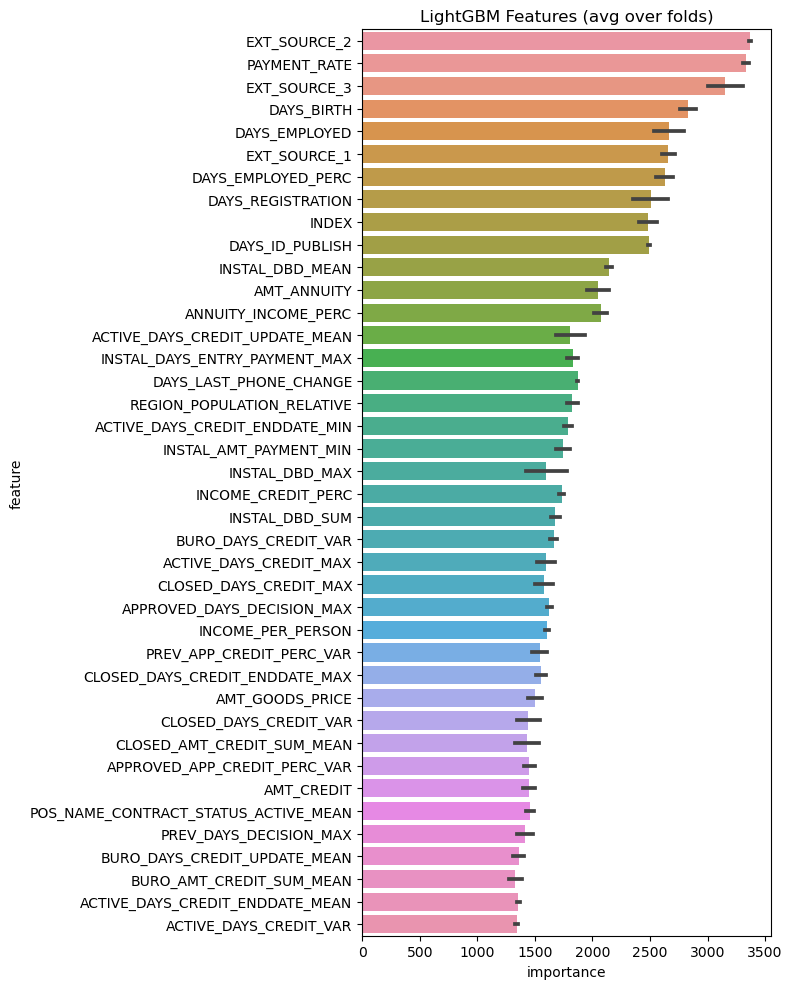

## Création des fichiers des df après pré-process

In [ ]:
# feat_important=['EXT_SOURCE_2','PAYMENT_RATE','EXT_SOURCE_3','DAYS_BIRTH','DAYS_EMPLOYED','EXT_SOURCE_1','DAYS_EMPLOYED_PERC','DAYS_REGISTRATION','INDEX','DAYS_ID_PUBLISH',
# 'INSTAL_DBD_MEAN','AMT_ANNUITY','ANNUITY_INCOME_PERC','ACTIVE_DAYS_CREDIT_UPDATE_MEAN','INSTAL_DAYS_ENTRY_PAYMENT_MAX','DAYS_LAST_PHONE_CHANGE','REGION_POPULATION_RELATIVE','ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
# 'CLOSED_DAYS_CREDIT_MAX','APPROVED_DAYS_DECISION_MAX','INCOME_PER_PERSON','PREV_APP_CREDIT_PERC_VAR','CLOSED_DAYS_CREDIT_ENDDATE_MAX','AMT_GOODS_PRICE','CLOSED_DAYS_CREDIT_VAR','CLOSED_AMT_CREDIT_SUM_MEAN',
# 'APPROVED_APP_CREDIT_PERC_VAR','AMT_CREDIT','POS_NAME_CONTRACT_STATUS_ACTIVE_MEAN','PREV_DAYS_DECISION_MAX','BURO_DAYS_CREDIT_UPDATE_MEAN','BURO_AMT_CREDIT_SUM_MEAN','ACTIVE_DAYS_CREDIT_ENDDATE_MEAN','ACTIVE_DAYS_CREDIT_VAR']

In [ ]:
# df_test_train
# df_bureau_balance
# df_prev_app
# df_pos_cash
# df_payments
# df_card_balance


In [ ]:
def visu_df(dataframe):
    return display('Shape',dataframe.shape,'Describe',dataframe.describe(),'Head',dataframe.head())

In [ ]:
df_test_train=application_train_test(num_rows = None, nan_as_category = False).copy()

In [ ]:
temp=df_test_train.set_index('SK_ID_CURR')
temp.index.rename('ID',inplace=True)
temp.insert(1,'SK_ID_CURR',temp.index)
temp.head()
df_test_train=temp.copy()

In [ ]:
visu_df(df_test_train)

In [ ]:
df_bureau_balance=bureau_and_balance(num_rows = None, nan_as_category = True).copy()

In [ ]:
visu_df(df_bureau_balance)

In [ ]:
df_prev_app=previous_applications(num_rows = None, nan_as_category = True).copy()

In [ ]:
visu_df(df_prev_app)

In [ ]:
df_pos_cash=pos_cash(num_rows = None, nan_as_category = True).copy()

In [ ]:
visu_df(df_pos_cash)

In [ ]:
df_payments=installments_payments(num_rows = None, nan_as_category = True).copy()

In [ ]:
visu_df(df_payments)

In [ ]:
df_card_balance=credit_card_balance(num_rows = None, nan_as_category = True).copy()

In [ ]:
visu_df(df_card_balance)

## Controle


In [ ]:
list_df=[df_test_train,df_prev_app,df_bureau_balance,df_payments,df_pos_cash,df_card_balance]

In [ ]:
def Controle(x):
    # DataFrame de contrôles sur les colonnes
    tempo = pd.DataFrame(columns=['nomcol', 'type', 'unique',
                    'unique%','doubl%' ,'manqu', 'manqu%', 'rempli', 'rempli%','skew'])

    tot = x.shape[0]

    tempo['nomcol'] = pd.Series(x.columns) # nom des colonnes

    for i in x.columns:
        j=list(x.columns).index(i)
        
        tempo.at[j, 'unique'] = len(x[i].unique())    # nbr de valeurs uniques prise par chaque colonne
        tempo.at[j, 'type'] = x.dtypes[i]             # type de données
        tempo.at[j, 'manqu'] = x.isnull().sum()[i]    # nombre de valeurs manquantes

        if x.isnull().sum()[i] != tot:               # valeurs uniques en % des données alimentées
            tempo.at[j, 'unique%'] = round(len(x[i].unique())/(tot-x.isnull().sum()[i])*100, 3)    
        else:
            tempo.at[j, 'unique%'] = 100   
        
 
        if tempo.at[j, 'unique'] ==1:                    # % de doublons
            tempo.at[j, 'doubl%'] = 100
    
        else:
            tempo.at[j, 'doubl%'] = 100-tempo.at[j, 'unique%']                        
    
        tempo.at[j, 'manqu%'] = round(x.isnull().sum()[i]/tot*100, 3)       # données manquantes en % du total
        tempo.at[j, 'rempli'] = tot-x.isnull().sum()[i]                     # données remplies (inverse des manquantes)
        tempo.at[j, 'rempli%'] = 100-round(x.isnull().sum()[i]/tot*100, 3)  # données remplies en %
    
    temp=x.describe().T.applymap('{:,.2f}'.format).copy()                  # describe des données numériques (min, max...)
    temp.drop(['count','std'],axis=1,inplace=True)                         # nombre et ecart-type pas ntéressants donc droppés
    tempo=tempo.merge(temp,how='left',left_on='nomcol',right_index=True)        # ajout des données numériques aux données de remplissage
    
    for i in tempo.loc[(tempo['type']!='category') & (tempo['type']!='object')]['nomcol']:                            #skew des données numériques
        tempo.at[tempo.loc[tempo['nomcol']==i].index.values[0],'skew']=x[i].skew()
    
    return tempo
# la fonction renvoie le dataframe de contrôle sur la base x fournie en variable

In [ ]:
# # 3 min pour le df de contrôle des données test_train
# ctrl_df_test_train=Controle(df_test_train).copy()

In [ ]:
# ctrl_df_test_train

In [ ]:
# ctrl_df_test_train.loc[abs(ctrl_df_test_train['skew'])>8]

In [ ]:
# df_test_train.iloc[:,247]

In [ ]:
# Controle(df_test_train.iloc[:,0:100])

In [ ]:
# Controle(df_test_train.iloc[:,100:200])

In [ ]:
# Controle(df_test_train.iloc[:,200:248])

In [ ]:
# ctrl_df_payments=Controle(df_payments).copy()
# ctrl_df_payments

In [ ]:
# ctrl_df_pos_cash=Controle(df_pos_cash).copy()
# ctrl_df_pos_cash

In [ ]:
# # 20 sec
# ctrl_df_card_balance=Controle(df_card_balance)
# ctrl_df_card_balance

In [ ]:
# #4 min 20
# ctrl_df_prev_app=Controle(df_prev_app)
# ctrl_df_prev_app

In [ ]:
# # 50 sec
# ctrl_df_bureau_balance=Controle(df_bureau_balance)
# ctrl_df_bureau_balance

In [ ]:
# ctrl_df_total_1=pd.concat([ctrl_df_test_train,ctrl_df_bureau_balance,ctrl_df_pos_cash,ctrl_df_card_balance,ctrl_df_prev_app,ctrl_df_payments])

In [ ]:
# ctrl_df_total_1

## Fichier des données test_train

In [ ]:
df_test_train.head()

In [ ]:
df_bureau_balance.head()

In [ ]:
df = pd.read_csv('0_données/application_train.csv')
df

In [ ]:
df_test = pd.read_csv('0_données/application_test.csv')
df_test

### Définition id_train et id_test

In [ ]:
id_train=df['SK_ID_CURR'].copy()
id_test=df_test['SK_ID_CURR'].copy()


In [ ]:
# df_pos_cash.loc[df_pos_cash.index.isin(id_train)].head()

In [ ]:
# df_pos_cash.loc[df_pos_cash.index.isin(id_test)].head()

### Définition infos train et test des fichiers

In [ ]:
for i in list_df:
    print(i.loc[i.index.isin(id_test)].shape[0],i.loc[i.index.isin(id_train)].shape[0],(i.loc[i.index.isin(id_test)].shape[0])/(i.shape[0]))

In [ ]:
list_df_namestrings=['df_test_train','df_prev_app','df_bureau_balance','df_payments','df_pos_cash','df_card_balance']


In [ ]:
dict_df=dict(zip(list_df_namestrings,list_df))


In [ ]:
df_infos_test_trains_fichiers=pd.DataFrame(data=list_df_namestrings,index=list_df_namestrings,columns=['namestrings'])
df_infos_test_trains_fichiers

In [ ]:
df_infos_test_trains_fichiers['Tot']=df_infos_test_trains_fichiers['namestrings'].apply(lambda x: dict_df.get(x).shape[0])
df_infos_test_trains_fichiers['dont train']=df_infos_test_trains_fichiers['namestrings'].apply(lambda x: dict_df.get(x).loc[(dict_df.get(x)).index.isin(id_train)].shape[0])
df_infos_test_trains_fichiers['dont test']=df_infos_test_trains_fichiers['namestrings'].apply(lambda x: dict_df.get(x).loc[(dict_df.get(x)).index.isin(id_test)].shape[0])    

In [ ]:
df_infos_test_trains_fichiers

In [ ]:
df_infos_test_trains_fichiers['train%']=(df_infos_test_trains_fichiers['dont train']/df_infos_test_trains_fichiers['Tot']).round(2)
df_infos_test_trains_fichiers['test%']=(df_infos_test_trains_fichiers['dont test']/df_infos_test_trains_fichiers['Tot']).round(2)

In [ ]:
df_infos_test_trains_fichiers

In [ ]:
df_test_train.index

### Test classif importance fichier par fichier

In [ ]:
#df_bureau_balance=df_bureau_balance.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')

In [ ]:
# kfold_lightgbm(df_bureau_balance, 2, stratified = False)

In [ ]:
#application_train_test()

In [ ]:
# df_prev_app=df_prev_app.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')
# df_pos_cash=df_pos_cash.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')
# df_payments=df_payments.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')
# df_card_balance=df_card_balance.merge(df_test_train['TARGET'],left_index=True,right_index=True,how='left')

In [ ]:
# df_prev_app=df_prev_app.drop(['TARGET_x','TARGET_y'],axis=1)

In [ ]:
# df_pos_cash=df_pos_cash.drop(['TARGET_x','TARGET_y'],axis=1)
# df_payments=df_payments.drop(['TARGET_x','TARGET_y'],axis=1)
# df_card_balance=df_card_balance.drop(['TARGET_x','TARGET_y'],axis=1)

In [ ]:
#df_prev_app.head()

In [ ]:
# kfold_lightgbm(df_prev_app, 2, stratified = False)

In [ ]:
# kfold_lightgbm(df_pos_cash, 2, stratified = False)

In [ ]:
# kfold_lightgbm(df_payments, 2, stratified = False)

In [ ]:
# kfold_lightgbm(df_card_balance, 2, stratified = False)

## FICHIER GLOBAL

In [ ]:
# df_total=df_test_train.merge(df_bureau_balance.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(df_prev_app.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(
#                                 df_pos_cash.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(df_payments.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').merge(    
#                                 df_card_balance.drop('TARGET',axis=1),left_index=True,right_index=True,how='left').copy()
# df_bureau_balance
# df_prev_app
# df_pos_cash
# df_payments
# df_card_balance

In [ ]:
df_total=df_test_train.merge(df_bureau_balance,left_index=True,right_index=True,how='left').merge(df_prev_app,left_index=True,right_index=True,how='left').merge(
                                df_pos_cash,left_index=True,right_index=True,how='left').merge(df_payments,left_index=True,right_index=True,how='left').merge(    
                                df_card_balance,left_index=True,right_index=True,how='left').copy()

In [ ]:
df_total = df_total.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_total = df_total.rename(columns = lambda x:x.upper())
for i in df_total.columns:
    if df_total[i].dtypes=='object':
        df_total[i]=df_total[i].astype('bool')

In [ ]:
visu_df(df_total)

## Old

In [ ]:
# data_ACP=df_total_sans_na.copy()

In [ ]:
# n_components = 100
# pca = PCA(n_components=n_components)
# names = data_ACP.index
# features = data_ACP.columns
# pca.fit(data_ACP)
# scree = (pca.explained_variance_ratio_*100).round(2)
# scree_cum = scree.cumsum().round()
# x_list = range(1, n_components+1)
# print('Variance_ratio:', pca.explained_variance_ratio_, '\n',
#       'Inerties:', scree, '\n',
#       'Inerties_cumulées', scree_cum)
# plt.bar(x_list, scree)
# plt.plot(x_list, scree_cum, c="red", marker='o')
# plt.xlabel("rang de l'axe d'inertie")
# plt.ylabel("pourcentage d'inertie")
# plt.title("Eboulis des valeurs propres")
# plt.grid()
# plt.ylim(0, 100)
# plt.xlim(0, 9)
# plt.show()

In [ ]:
# pcs = pca.components_
# pcs = pd.DataFrame(pcs)
# pcs.columns = features
# pcs.index = [f"F{i}" for i in x_list]
# pcs.round(4)

In [ ]:
# def correlation_graph(pca,
#                       x_y,
#                       features):
#     """Affiche le graphe des correlations

#     Positional arguments : 
#     -----------------------------------
#     pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
#     x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
#     features : list ou tuple : la liste des features (ie des dimensions) à représenter
#     """

#     # Extrait x et y
#     x, y = x_y

#     # Taille de l'image (en inches)
#     fig, ax = plt.subplots(figsize=(10, 9))

#     # Pour chaque composante :
#     for i in range(0, pca.components_.shape[1]):

#         # Les flèches
#         ax.arrow(0, 0,
#                  pca.components_[x, i],
#                  pca.components_[y, i],
#                  head_width=0.07,
#                  head_length=0.07,
#                  width=0.02, )

#         # Les labels
#         plt.text(pca.components_[x, i] + 0.05,
#                  pca.components_[y, i] + 0.05,
#                  features[i])

#     # Affichage des lignes horizontales et verticales
#     plt.plot([-1, 1], [0, 0], color='grey', ls='--')
#     plt.plot([0, 0], [-1, 1], color='grey', ls='--')
#     plt.grid()

#     # Nom des axes, avec le pourcentage d'inertie expliqué
#     plt.xlabel('F{} ({}%)'.format(
#         x+1, round(100*pca.explained_variance_ratio_[x], 1)))
#     plt.ylabel('F{} ({}%)'.format(
#         y+1, round(100*pca.explained_variance_ratio_[y], 1)))

#     # Titre
#     plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

#     # Le cercle
#     an = np.linspace(0, 2 * np.pi, 100)
#     plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

#     # Axes et display
#     plt.axis('equal')
#     plt.show(block=False)

In [ ]:
# correlation_graph(pca, (0, 1), features)

In [ ]:
# correlation_graph(pca, (0, 2), features)

In [ ]:
# correlation_graph(pca, (1, 2), features)

In [ ]:
# correlation_graph(pca, (0, 3), features)

# Utilisation des données lightgbm


In [ ]:
feature_importance=pd.read_csv('1_outputs/feature_importance.csv')

In [ ]:
temp=pd.crosstab(index=feature_importance['feature'],columns=['Importance_moyenne'],values=feature_importance['importance'],aggfunc='mean')

In [ ]:
sns.lineplot(x=range(temp.shape[0]),y=temp.sort_values(by='Importance_moyenne',ascending=False)['Importance_moyenne'])

In [ ]:
temp.sort_values(by='Importance_moyenne', ascending=False)[:50]

In [ ]:
feat_important=temp.sort_values(by='Importance_moyenne',ascending=False).index.values

In [ ]:
feat_important

In [ ]:
pd.Series(feat_important,dtype='str').to_csv('1_outputs/feat_important_sorted_decroissant.csv',index=False,header=False)


## def d'un lightgbm sur 100 à 200 var les plus importantes:

In [ ]:
var_lgbm_10=np.append(feat_important[:10],'TARGET')
var_lgbm_30=np.append(feat_important[:30],'TARGET')
var_lgbm_50=np.append(feat_important[:50],'TARGET')
var_lgbm_100=np.append(feat_important[:100],'TARGET')
var_lgbm_200=np.append(feat_important[:200],'TARGET')
var_lgbm_10

In [ ]:
# redéfinition d'un jeu de test/training à l'intérieur du jeu de train initial pour évaluer les résultats

random.seed(8)  # seed fixée pour reproductibilité des résultats
# jeu d'apprentissage
train_df = df_total[df_total['TARGET'].notnull()]
test_df = df_total[df_total['TARGET'].isnull()]

Liste_train = list(random.sample(list(train_df.index), round(train_df.shape[0]*0.8)))
Liste_test = train_df.loc[train_df.index.isin(Liste_train)==False,:].index.values


In [ ]:
df_total[var_lgbm_10].head()

In [ ]:
# def main_eval_var(debug = False):
#     num_rows = 10000 if debug else None
#     df = application_train_test(num_rows)
#     with timer("Process bureau and bureau_balance"):
#         bureau = bureau_and_balance(num_rows)
#         print("Bureau df shape:", bureau.shape)
#         df = df.join(bureau, how='left', on='SK_ID_CURR')
#         del bureau
#         gc.collect()
#     with timer("Process previous_applications"):
#         prev = previous_applications(num_rows)
#         print("Previous applications df shape:", prev.shape)
#         df = df.join(prev, how='left', on='SK_ID_CURR')
#         del prev
#         gc.collect()
#     with timer("Process POS-CASH balance"):
#         pos = pos_cash(num_rows)
#         print("Pos-cash balance df shape:", pos.shape)
#         df = df.join(pos, how='left', on='SK_ID_CURR')
#         del pos
#         gc.collect()
#     with timer("Process installments payments"):
#         ins = installments_payments(num_rows)
#         print("Installments payments df shape:", ins.shape)
#         df = df.join(ins, how='left', on='SK_ID_CURR')
#         del ins
#         gc.collect()
#     with timer("Process credit card balance"):
#         cc = credit_card_balance(num_rows)
#         print("Credit card balance df shape:", cc.shape)
#         df = df.join(cc, how='left', on='SK_ID_CURR')
#         del cc
#         gc.collect()
    
# ## Modif "eval_var", on restreint le df
#     df=df[var_lgbm].copy()


#     with timer("Run LightGBM with kfold"):
#         feat_importance = kfold_lightgbm(df, num_folds= 2, stratified= False, debug= debug)

In [ ]:
# def kfold_lightgbm_var_import(df, num_folds, stratified = False, debug= False):
#     # Divide in training/validation and test data
#     df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
#     df = df.rename(columns = lambda x:x.upper())
    
#     for i in df.columns:
#         if df[i].dtypes=='object':
#             df[i]=df[i].astype('bool')
#     train_df = df[df['TARGET'].notnull()].loc[Liste_train]
#     test_df = df[df['TARGET'].notnull()].loc[Liste_test]
#     print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    
#     # # Cross validation model
#     # if stratified:
#     #     folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
#     # else:
#     #     folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
#     # Create arrays and dataframes to store results
#     global clf, oof_preds, sub_preds, feature_importance_df
#     oof_preds = np.zeros(train_df.shape[0])
#     sub_preds = np.zeros(test_df.shape[0])
#     feature_importance_df = pd.DataFrame()
#     feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
#     for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
#         train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
#         valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

#         # LightGBM parameters found by Bayesian optimization
        
#         clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )

#         clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

#         oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
#         sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

#         fold_importance_df = pd.DataFrame()
#         fold_importance_df["feature"] = feats
#         fold_importance_df["importance"] = clf.feature_importances_
#         fold_importance_df["fold"] = n_fold + 1

#         feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
#         print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
#         del clf, train_x, train_y, valid_x, valid_y
#         gc.collect()

#     print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
#     # Write submission file and plot feature importance
    
#     display_importances(feature_importance_df)
#     return feature_importance_df

## Calculs avec changements du nbr de var retenues

 lgbm + _10 ,  _30,  _50 , _100 , _200 = nombre de variables classées selon l'importance retenues + comparaison aux stats "réelles" en conservant la totalité 

In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total[var_lgbm_10]
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_10=train_x.copy()
# train_y_10=train_y.copy()
# valid_x_10=valid_x.copy()
# valid_y_10=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# ## NBR VAR à changer manuellement ##
# predict_train_10=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid_10=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )
# ## NBR VAR à changer manuellement ##


# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))


In [ ]:
# (pd.crosstab(valid_y,predict_valid,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(train_y,predict_train,normalize='index')*100).round(3)

In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total[var_lgbm_30]
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_30=train_x.copy()
# train_y_30=train_y.copy()
# valid_x_30=valid_x.copy()
# valid_y_30=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# ## NBR VAR à changer manuellement ##
# predict_train_30=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid_30=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )
# ## NBR VAR à changer manuellement ##


# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))


In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total[var_lgbm_50]
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_50=train_x.copy()
# train_y_50=train_y.copy()
# valid_x_50=valid_x.copy()
# valid_y_50=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# ## NBR VAR à changer manuellement ##
# predict_train_50=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid_50=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )
# ## NBR VAR à changer manuellement ##


# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))

In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total[var_lgbm_100]
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_100=train_x.copy()
# train_y_100=train_y.copy()
# valid_x_100=valid_x.copy()
# valid_y_100=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# predict_train=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )

# ## NBR VAR à changer manuellement ##
# predict_train_100=predict_train.copy()
# predict_valid_100=predict_valid.copy()
# ## NBR VAR à changer manuellement ##

# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y_100,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))

In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total[var_lgbm_200]
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_200=train_x.copy()
# train_y_200=train_y.copy()
# valid_x_200=valid_x.copy()
# valid_y_200=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# predict_train=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )

# ## NBR VAR à changer manuellement ##
# predict_train_200=predict_train.copy()
# predict_valid_200=predict_valid.copy()
# ## NBR VAR à changer manuellement ##

# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))

In [ ]:
# ## NBR VAR à changer manuellement ##
# df=df_total
# ## NBR VAR à changer manuellement ##

# train_df = df[df['TARGET'].notnull()].loc[Liste_train]
# test_df = df[df['TARGET'].notnull()].loc[Liste_test]

# feature_importance_df = pd.DataFrame()
# feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
# train_x, train_y = train_df[feats], train_df['TARGET']
# valid_x, valid_y = test_df[feats], test_df['TARGET']

# ## NBR VAR à changer manuellement ##
# train_x_tot=train_x.copy()
# train_y_tot=train_y.copy()
# valid_x_tot=valid_x.copy()
# valid_y_tot=valid_y.copy()
# ## NBR VAR à changer manuellement ##


# clf = LGBMClassifier(
#             nthread=4,
#             n_estimators=10000,
#             learning_rate=0.02,
#             num_leaves=34,
#             colsample_bytree=0.9497036,
#             subsample=0.8715623,
#             max_depth=8,
#             reg_alpha=0.041545473,
#             reg_lambda=0.0735294,
#             min_split_gain=0.0222415,
#             min_child_weight=39.3259775,
#             silent=-1,
#             verbose=-1, )


# clf_fit=clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
#             eval_metric= 'auc')

# # oof_preds[1] = clf.predict_proba(valid_x)[:, 1]
# # sub_preds += clf.predict_proba(test_df[feats])[:, 1]

# fold_importance_df = pd.DataFrame()
# fold_importance_df["feature"] = feats
# fold_importance_df["importance"] = clf.feature_importances_
# fold_importance_df["fold"] = 1

# feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# predict_train=pd.Series(clf_fit.predict(train_x),index=train_df.index, name ='predict_train')
# predict_valid=pd.Series(clf_fit.predict(valid_x),index=test_df.index, name ='predict_valid' )

# ## NBR VAR à changer manuellement ##
# predict_train_tot=predict_train.copy()
# predict_valid_tot=predict_valid.copy()
# ## NBR VAR à changer manuellement ##


# # score ARI training
# print('score ARI training =',round(adjusted_rand_score(train_y,predict_train),3))
# # score ARI testing
# print('score ARI testing =',round(adjusted_rand_score(valid_y,predict_valid),3))
# # accuracy training
# print('accuracy training =',round(sklearn.metrics.accuracy_score(train_y, predict_train),3))
# # accuracy testing
# print('accuracy testing =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid),3))
# # precision training
# print('precision training =',round(sklearn.metrics.average_precision_score(train_y, predict_train),3))
# # precision testing
# print('precision testing =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid),3))

In [ ]:
# (pd.crosstab(train_y_tot,predict_train_tot,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(train_y_200,predict_train_200,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(train_y_100,predict_train_100,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(train_y_50,predict_train_50,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(train_y_30,predict_train_30,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(valid_y_tot,predict_valid_tot,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(valid_y_200,predict_valid_200,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(valid_y_100,predict_valid_100,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(valid_y_50,predict_valid_50,normalize='index')*100).round(3)

In [ ]:
# (pd.crosstab(valid_y_30,predict_valid_30,normalize='index')*100).round(3)

In [ ]:
# lgbm_valid_y=pd.concat([valid_y_30,predict_valid_30,predict_valid_50,predict_valid_100,predict_valid_200,predict_valid_tot],axis=1)
# lgbm_valid_y.columns=['TARGET',30,50,100,200,'tot']
# lgbm_train_y=pd.concat([train_y_30,predict_train_30,predict_train_50,predict_train_100,predict_train_200,predict_train_tot],axis=1)
# lgbm_train_y.columns=['TARGET',30,50,100,200,'tot']
# lgbm_result_tot=pd.concat([lgbm_train_y,lgbm_valid_y],axis=0)


In [ ]:
# lgbm_result_tot

### sauvegarge des résultats du lgbm avec nbr de var distinctes

In [ ]:
# lgbm_result_tot.to_csv('1_outputs/Result_lgbm_nbr_var.csv')

In [ ]:
# pd.crosstab(lgbm_valid_y['TARGET'],lgbm_valid_y[30])

In [ ]:
# pd.crosstab(lgbm_train_y['TARGET'],lgbm_train_y[30])

In [ ]:
# print('','precision testing_tot =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid_tot),4),'\n',
#     'precision testing_200 =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid_200),4),'\n',
#     'precision testing_100 =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid_100),4),'\n',
#     'precision testing_50 =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid_50),4),'\n',
#     'precision testing_30 =',round(sklearn.metrics.average_precision_score(valid_y, predict_valid_30),4)
    # )

In [ ]:
# print('','precision testing_tot =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid_tot),4),'\n',
#     'precision testing_200 =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid_200),4),'\n',
#     'precision testing_100 =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid_100),4),'\n',
#     'precision testing_50 =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid_50),4),'\n',
#     'precision testing_30 =',round(sklearn.metrics.accuracy_score(valid_y, predict_valid_30),4)
#     )

Garder uniquement 100 variables "maximise" la précision sur les différents essais avec moins de variables =>  on simplifie  pour les modèles de scoring en réduisant les temps de calcul. On peut aussi considérer que d'une point de vue explication du résultat du score et gestion des informations, un modèle efficace avec moin s de variables requises serait un plus

In [ ]:
# recharge des résultats obtenus pour les executions du code sans recalcul des lgbm sur différents nbr de variables
lgbm_result_tot=pd.read_csv('1_outputs/Result_lgbm_nbr_var.csv')

# Modèles de classification sur les bases des 100 var les plus importantes

In [ ]:
data=df_total[var_lgbm_100].copy()

### exploration

In [ ]:
df_total[var_lgbm_100].head()

In [ ]:
ctrl_data=Controle(df_total[var_lgbm_100])

In [ ]:
ctrl_data

In [ ]:
ctrl_data[ctrl_data['nomcol'].str.contains('_VAR')]

In [ ]:
ctrl_data.loc[abs(ctrl_data['skew'])>8,:]


In [ ]:
skew_a_corriger=ctrl_data.loc[abs(ctrl_data['skew'])>8,'nomcol']
skew_a_corriger

In [ ]:
ctrl_data.loc[ctrl_data['nomcol']=='ACTIVE_DAYS_CREDIT_UPDATE_MEAN','min']

In [ ]:
data2=data.copy()
# data[skew_a_corriger].apply(lambda x: x+min(x,0),axis=1)
for i in skew_a_corriger:
    data2[i]=np.log(data[i]-min(data[i].min(),0)+2)

In [ ]:
ctrl_data2=Controle(data2)

In [ ]:
ctrl_data2.loc[ctrl_data2['nomcol'].isin(skew_a_corriger),:]


In [ ]:
temp=data['INSTAL_PAYMENT_PERC_VAR'].value_counts()
temp

In [ ]:
data['INSTAL_PAYMENT_PERC_VAR'].sort_values(ascending=False)[0:50]

In [ ]:
# version simplifiée du df de contrôle: donnée de type, Skew de la série et valeurs du describe + quntile à 99%
def Skew_df(x):
    # DataFrame de contrôles sur les colonnes
    tempo = pd.DataFrame(columns=['type','skew'])

    tot = x.shape[0]

    tempo['nomcol'] = pd.Series(x.columns) # nom des colonnes

    for i in x.columns:
        j=list(x.columns).index(i)
        tempo.at[j, 'type'] = x.dtypes[i]
        tempo.at[j, '99%'] = np.percentile(x.loc[x[i].isna()==False,i],99)  # retirer les Nan pour calcul du percentile
       
    
    temp=x.describe().T.copy()                  # describe des données numériques (min, max...)
    temp.drop(['count','std'],axis=1,inplace=True)                         # nombre et ecart-type pas ntéressants donc droppés
    tempo=tempo.merge(temp,how='left',left_on='nomcol',right_index=True)        # ajout des données numériques aux données de remplissage
        
        
    for i in tempo.loc[(tempo['type']!='category') & (tempo['type']!='object')]['nomcol']:                            #skew des données numériques
        tempo.at[tempo.loc[tempo['nomcol']==i].index.values[0],'skew']=x[i].skew()
    return tempo

In [ ]:
ctrl_data2=Skew_df(data2)

In [ ]:
ctrl_data2

In [ ]:
ctrl_data2.loc[ctrl_data2['nomcol']=='INSTAL_PAYMENT_PERC_VAR','99%'].values[0]

In [ ]:
data2.loc[data2['INSTAL_PAYMENT_PERC_VAR']<ctrl_data2.loc[ctrl_data2['nomcol']=='INSTAL_PAYMENT_PERC_VAR','99%'].values[0],'INSTAL_PAYMENT_PERC_VAR']

In [ ]:
sns.histplot(data2.loc[data2['INSTAL_PAYMENT_PERC_VAR']<ctrl_data2.loc[ctrl_data2['nomcol']=='INSTAL_PAYMENT_PERC_VAR','99%'].values[0],'INSTAL_PAYMENT_PERC_VAR'])
plt.xlim(0,3)
plt.ylim(0,5000)

### opérations finales de feature engineering

In [ ]:
data.head()

In [ ]:
data2=data.copy()

In [ ]:
#data2: remplacement des valeurs inf par des Nan (si jamais les colonnes de variables conservées inculent des valeurs inf)
for col in data.loc[:,data.max(axis=0)==np.inf].columns:
    data2[col] = data[col].replace([np.inf, -np.inf], np.nan)


In [ ]:
data3=data2.copy()

In [ ]:
#data3: cap max à quant75%+10* ecart interquartile(75-25)
def clip_quart(col):
    return col.clip(upper=np.percentile(col.loc[col.isna()==False],75)+
                    10*(np.percentile(col.loc[col.isna()==False],75)-np.percentile(col.loc[col.isna()==False],25)),
                    lower=np.percentile(col.loc[col.isna()==False],25)-
                    10*(np.percentile(col.loc[col.isna()==False],75)-np.percentile(col.loc[col.isna()==False],25)))


data3=data2.apply(clip_quart,axis=0)


In [ ]:
ctrl_data2=Skew_df(data2)
ctrl_data3=Skew_df(data3)

In [ ]:
ctrl_data2.sort_values(by='skew')

In [ ]:
ctrl_data3.sort_values(by='skew')

In [ ]:
display(ctrl_data2.loc[ctrl_data2['nomcol']=='AMT_INCOME_TOTAL'],ctrl_data3.loc[ctrl_data3['nomcol']=='AMT_INCOME_TOTAL'])


In [ ]:
data4=data3.copy()

In [ ]:
#data4: retrait des na
for col in data3.columns:
    data4[col]=data3[col].fillna(data3[col].mean())

In [ ]:
data5=data4.copy()

In [ ]:
#data5 = arrondi à 4 chiffres après virgule
data5=data5.round(4)

In [ ]:
# data6 = standard Scale de data5

scale=StandardScaler()
data6=pd.DataFrame(data=scale.fit_transform(data5),index=data5.index,columns=data5.columns).round(4)

# attention: l'étape 3 de l'écart interquartile fait passer la variable TARGET à 0 car dans la distribution initiale, les quant à 25 et 75% ont pour valeur 0
# le cap plafonds fait donc disparaitre tous les 1
# on repasse la valeur de TARGET à sa valeur initiale + les 'NA' de target inconnue (les indiv à évaluer) sont passés à -1 (pour différencier des 0 accord et 1 refus)
data6['TARGET']=data['TARGET'].fillna(-1)



In [ ]:
data6.to_csv("1_outputs/data6.csv")

# opérations de création de la base



obtention de df_total

In [5]:
# Création des dataframes issus des fichiers sources séparés et de df_total
df_test_train=application_train_test(num_rows = None, nan_as_category = False).copy()

temp=df_test_train.set_index('SK_ID_CURR')
temp.index.rename('ID',inplace=True)
temp.insert(1,'SK_ID_CURR',temp.index)
temp.head()
df_test_train=temp.copy()

df_bureau_balance=bureau_and_balance(num_rows = None, nan_as_category = True).copy()
df_prev_app=previous_applications(num_rows = None, nan_as_category = True).copy()
df_pos_cash=pos_cash(num_rows = None, nan_as_category = True).copy()
df_payments=installments_payments(num_rows = None, nan_as_category = True).copy()
df_card_balance=credit_card_balance(num_rows = None, nan_as_category = True).copy()

df_total=df_test_train.merge(df_bureau_balance,left_index=True,right_index=True,how='left').merge(df_prev_app,left_index=True,right_index=True,how='left').merge(
                                df_pos_cash,left_index=True,right_index=True,how='left').merge(df_payments,left_index=True,right_index=True,how='left').merge(    
                                df_card_balance,left_index=True,right_index=True,how='left').copy()

df_total = df_total.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df_total = df_total.rename(columns = lambda x:x.upper())
for i in df_total.columns:
    if df_total[i].dtypes=='object':
        df_total[i]=df_total[i].astype('bool')


Train samples: 307511, test samples: 48744


In [ ]:
df_total['SK_ID_CURR'].to_csv('1_outputs/Liste_index_clients.csv')

In [7]:
# 6 min 30
# enregistrement de df_total = intégralité des données en un dataframe
df_total.to_csv('1_outputs/df_total.csv', index = True,sep='\t',compression='gzip')

In [4]:
# 45 sec
# chargement depuis le répertoire au besoin
df_total=pd.read_csv("1_outputs/df_total.csv",sep='\t',compression='gzip',index_col='ID')


In [5]:
# Histo : base avec TARGET connue pour entrainer et tester le modèle
# Futur : base avec TARGET inconnue pour API dashboard et data drift
base_futur=df_total.loc[df_total['TARGET'].isna()]
base_futur.to_csv('1_outputs/base_futur.csv', index = True,sep='\t',compression='gzip')
base_histo=df_total.loc[df_total['TARGET'].isna()==False]
base_histo.to_csv('1_outputs/base_histo.csv', index = True,sep='\t',compression='gzip')

In [6]:
base_histo['SK_ID_CURR'].to_csv('1_outputs/Liste_index_clients_histo.csv')
# les données base futur servent à l'api est sont envoyées dans le rep dédié
base_futur['SK_ID_CURR'].to_csv('2_backend/API_input_data/Liste_index_clients_futur.csv')

In [ ]:
# OLD, avant simplifications

# #etape 1: renomme copies
# data=base_histo
# data2=data.copy()

# #etape 2: remplacement des valeurs inf par des Nan (si jamais les colonnes de variables conservées inculent des valeurs inf)
# for col in data.loc[:,data.max(axis=0)==np.inf].columns:
#     data2[col] = data[col].replace([np.inf, -np.inf], np.nan)

# #etape 3: cap max à quant75%+10* ecart interquartile(75-25)
# def clip_quart(col):
#     return col.clip(upper=np.percentile(col.loc[col.isna()==False],75)+
#                     10*(np.percentile(col.loc[col.isna()==False],75)-np.percentile(col.loc[col.isna()==False],25)),
#                     lower=np.percentile(col.loc[col.isna()==False],25)-
#                     10*(np.percentile(col.loc[col.isna()==False],75)-np.percentile(col.loc[col.isna()==False],25)))

# data3=data2.copy()
# data3.loc[:,data3.dtypes!='bool']=data2.loc[:,data3.dtypes!='bool'].apply(clip_quart,axis=0)

# #etape 4: retrait des na: remplissage par la moyenne
# data4=data3.copy()
# for col in data3.columns:
#     data4[col]=data3[col].fillna(data3[col].mean())

# #etape 5 = standard Scale de data4

# scale=StandardScaler()
# data5=pd.DataFrame(data=scale.fit_transform(data4),index=data4.index,columns=data4.columns).round(4)

# # attention: l'étape 3 de l'écart interquartile fait passer la variable TARGET à 0 car dans la distribution initiale, les quant à 25 et 75% ont pour valeur 0
# # le cap plafonds fait donc disparaitre tous les 1
# # on repasse la valeur de TARGET à sa valeur initiale

# # on conserve aussi data4 comme base à utiliser dans l'explainer SHAP => valeurs avant standard-scale 
# data4['TARGET']=data['TARGET']
# data5['TARGET']=data['TARGET']

# # étape 6 : format plus réduit
# data6=data5.astype('float32')
# data7=data4.astype('float32')


In [ ]:
# # Version def des mises en forme, base histo

# #etape 1: renomme copies
# data=base_histo
# data2=data.copy()

# #etape 2: remplacement des valeurs inf par des Nan (si jamais les colonnes de variables conservées inculent des valeurs inf)
# data2.replace([np.inf, -np.inf], np.nan, inplace=True)

# #etape 2.5 : si TARGET est NA (base_futur des clients pour lesquels le résultat du prêt n'est pas connu), remplacer par des -1
# data2['TARGET']=np.where(data2['TARGET'].isna(),-1,data2['TARGET'])

# #etape 3: cap max à quant75%+10* ecart interquartile(75-25)

# def clip_quart(col):
#     quant_25 = np.percentile(col.loc[col.notna()], 25)
#     quant_75 = np.percentile(col.loc[col.notna()], 75)
#     upper_bound = quant_75 + 10 * (quant_75 - quant_25)
#     lower_bound = quant_25 - 10 * (quant_75 - quant_25)
#     return col.clip(upper=upper_bound, lower=lower_bound)

# data2.loc[:,data2.dtypes!='bool']=data2.loc[:,data2.dtypes!='bool'].apply(clip_quart,axis=0)

# #etape 4: retrait des na: remplissage par la moyenne
# data2.fillna(data2.mean(), inplace=True)

# #etape 5 = standard Scale de data4
# scale=StandardScaler()
# data3 = pd.DataFrame(scale.fit_transform(data2), index=data2.index, columns=data2.columns).round(4)
# # attention: l'étape 3 de l'écart interquartile fait passer la variable TARGET à 0 car dans la distribution initiale, les quant à 25 et 75% ont pour valeur 0
# # le cap plafonds fait donc disparaitre tous les 1
# # on repasse la valeur de TARGET à sa valeur initiale

# # on conserve aussi data4 comme base à utiliser dans l'explainer SHAP => valeurs avant standard-scale 
# data2['TARGET']=data['TARGET']
# data3['TARGET']=data['TARGET']

# # étape 6 : format plus réduit
# data2=data2.astype('float32')
# data3=data3.astype('float32')


In [ ]:
# # Version def des mises en forme, base futur

# #etape 1: renomme copies
# data=base_futur
# data2=data.copy()

# #etape 2: remplacement des valeurs inf par des Nan (si jamais les colonnes de variables conservées inculent des valeurs inf)
# data2.replace([np.inf, -np.inf], np.nan, inplace=True)

# #etape 2.5 : si TARGET est NA (base_futur des clients pour lesquels le résultat du prêt n'est pas connu), remplacer par des -1
# data2['TARGET']=np.where(data2['TARGET'].isna(),-1,data2['TARGET'])

# #etape 3: cap max à quant75%+10* ecart interquartile(75-25)

# def clip_quart(col):
#     quant_25 = np.percentile(col.loc[col.notna()], 25)
#     quant_75 = np.percentile(col.loc[col.notna()], 75)
#     upper_bound = quant_75 + 10 * (quant_75 - quant_25)
#     lower_bound = quant_25 - 10 * (quant_75 - quant_25)
#     return col.clip(upper=upper_bound, lower=lower_bound)

# data2.loc[:,data2.dtypes!='bool']=data2.loc[:,data2.dtypes!='bool'].apply(clip_quart,axis=0)

# #etape 4: retrait des na: remplissage par la moyenne
# data2.fillna(data2.mean(), inplace=True)

# #etape 5 = standard Scale de data4
# scale=StandardScaler()
# data3 = pd.DataFrame(scale.fit_transform(data2), index=data2.index, columns=data2.columns).round(4)
# # attention: l'étape 3 de l'écart interquartile fait passer la variable TARGET à 0 car dans la distribution initiale, les quant à 25 et 75% ont pour valeur 0
# # le cap plafonds fait donc disparaitre tous les 1
# # on repasse la valeur de TARGET à sa valeur initiale

# # on conserve aussi data2 comme base à utiliser dans l'explainer SHAP => valeurs avant standard-scale 
# data2['TARGET']=np.where(data['TARGET'].isna(),-1,data['TARGET'])
# data3['TARGET']=np.where(data['TARGET'].isna(),-1,data['TARGET'])

# # étape 6 : format plus réduit
# data2=data2.astype('float32')
# data3=data3.astype('float32')


In [9]:
def mise_en_forme_pre_std_scale(dataframe):

    #etape 1: renomme copies
    data=dataframe
    data2=data.copy()

    #etape 2: remplacement des valeurs inf par des Nan (si jamais les colonnes de variables conservées inculent des valeurs inf)
    data2.replace([np.inf, -np.inf], np.nan, inplace=True)

    #etape 2.5 : si TARGET est NA (base_futur des clients pour lesquels le résultat du prêt n'est pas connu), remplacer par des -1
    data2['TARGET']=np.where(data2['TARGET'].isna(),-1,data2['TARGET'])

    #etape 3: cap max à quant75%+10* ecart interquartile(75-25)

    def clip_quart(col):
        quant_25 = np.percentile(col.loc[col.notna()], 25)
        quant_75 = np.percentile(col.loc[col.notna()], 75)
        upper_bound = quant_75 + 10 * (quant_75 - quant_25)
        lower_bound = quant_25 - 10 * (quant_75 - quant_25)
        return col.clip(upper=upper_bound, lower=lower_bound)

    data2.loc[:,data2.dtypes!='bool']=data2.loc[:,data2.dtypes!='bool'].apply(clip_quart,axis=0)

    #etape 4: retrait des na: remplissage par la moyenne
    data2.fillna(data2.mean(), inplace=True)

    # attention: l'étape 3 de l'écart interquartile fait passer la variable TARGET à 0 car dans la distribution initiale, les quant à 25 et 75% ont pour valeur 0
    # le cap plafonds fait donc disparaitre tous les 1
    # on repasse la valeur de TARGET à sa valeur initiale

    data2['TARGET']=data['TARGET']

    # étape 6 : format plus réduit
    data2=data2.astype('float32')

    return data2


In [10]:
def mise_en_forme_yc_std_scale(dataframe):

    #etape 1: renomme copies
    data=dataframe
    data2=data.copy()

    #etape 2: remplacement des valeurs inf par des Nan (si jamais les colonnes de variables conservées inculent des valeurs inf)
    data2.replace([np.inf, -np.inf], np.nan, inplace=True)

    #etape 2.5 : si TARGET est NA (base_futur des clients pour lesquels le résultat du prêt n'est pas connu), remplacer par des -1
    data2['TARGET']=np.where(data2['TARGET'].isna(),-1,data2['TARGET'])

    #etape 3: cap max à quant75%+10* ecart interquartile(75-25)

    def clip_quart(col):
        quant_25 = np.percentile(col.loc[col.notna()], 25)
        quant_75 = np.percentile(col.loc[col.notna()], 75)
        upper_bound = quant_75 + 10 * (quant_75 - quant_25)
        lower_bound = quant_25 - 10 * (quant_75 - quant_25)
        return col.clip(upper=upper_bound, lower=lower_bound)

    data2.loc[:,data2.dtypes!='bool']=data2.loc[:,data2.dtypes!='bool'].apply(clip_quart,axis=0)

    #etape 4: retrait des na: remplissage par la moyenne
    data2.fillna(data2.mean(), inplace=True)

    #etape 5 = standard Scale de data4
    scale=StandardScaler()
    data3 = pd.DataFrame(scale.fit_transform(data2), index=data2.index, columns=data2.columns).round(4) 

    # attention: l'étape 3 de l'écart interquartile fait passer la variable TARGET à 0 car dans la distribution initiale, les quant à 25 et 75% ont pour valeur 0
    # le cap plafonds fait donc disparaitre tous les 1
    # on repasse la valeur de TARGET à sa valeur initiale

    data3['TARGET']=data['TARGET']

    # étape 6 : format plus réduit
    data3=data3.astype('float32')

    return data3

In [ ]:

base_histo.shape[0]

In [ ]:
# 7 min 20
# Sauvegarde de la base_histo après mise en forme des données pour etre directement utilisable par les algos
data7.to_csv("1_outputs/base_histo_prep_shap.csv",sep='\t',compression='gzip')

In [11]:
# enregistrement sur le disque = 1 min
# Sauvegarde de la base_futur après mise en forme des données pour etre directement utilisable par les algos
mise_en_forme_yc_std_scale(base_futur).to_csv("1_outputs/base_futur_prep_algo.csv",sep='\t',compression='gzip')

In [14]:
# enregistrement sur le disque = 1 min
# Sauvegarde de la base_futur après mise en forme des données pour etre directement utilisable par les algos
mise_en_forme_pre_std_scale(base_futur).to_csv("1_outputs/base_futur_prep_shap.csv",sep='\t',compression='gzip')

In [15]:
# 7 min 20
# Sauvegarde de la base_histo après mise en forme des données pour etre directement utilisable par les algos
mise_en_forme_yc_std_scale(base_histo).to_csv("1_outputs/base_histo_prep_algo.csv",sep='\t',compression='gzip')

# 2: Import de la base de données préparée

In [19]:
# 40 sec
base=pd.read_csv("1_outputs/base_histo_prep_algo.csv",sep='\t',compression='gzip',index_col='ID')
base_histo=pd.read_csv("1_outputs/base_histo.csv",sep='\t',compression='gzip',index_col='ID')
base_futur=pd.read_csv("1_outputs/base_futur.csv",sep='\t',compression='gzip',index_col='ID')

In [20]:
feat_important_sorted_decroissant=pd.Series(pd.read_csv('1_outputs/feat_important_sorted_decroissant.csv',header=None)[0])
feat_important_sorted_decroissant=feat_important_sorted_decroissant.array
var_lgbm_100=np.append(feat_important_sorted_decroissant[:100],'TARGET')

In [21]:
base_100=base[var_lgbm_100]

# ACP - TSNE

## base totale

In [ ]:
data_ACP=base.copy()

In [ ]:

n_components = data_ACP.shape[1]-1
pca = decomposition.PCA(n_components=n_components)
names = data_ACP.index
features = data_ACP.columns
pca.fit(data_ACP)
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = range(1, n_components+1)
print('Variance_ratio:', pca.explained_variance_ratio_, '\n',
      'Inerties:', scree, '\n',
      'Inerties_cumulées', scree_cum)
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum, c="red", marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.grid()
plt.ylim(0, 100)
plt.xlim(0, data_ACP.shape[1]-1)
plt.show()

In [ ]:
print(data_ACP.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pd.DataFrame(pca.fit_transform(data_ACP),index=data_ACP.index)
print(feat_pca.shape)

In [ ]:
print(base_100.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca_100=pd.DataFrame(pca.fit_transform(base_100),index=base_100.index)
print(feat_pca_100.shape)

In [ ]:
print(' Tx de compression à 99% de variance sur base =',round(feat_pca.shape[1]/data_ACP.shape[1],4),'\n',
      'Tx de compression à 99% de variance sur base_100 =',round(feat_pca_100.shape[1]/base_100.shape[1],4))

La réalisation d'une ACP montre que les 100 variables retenues sont globalement importantes pour expliquer la variance <br>
Une ACP qui conserve 99% de la variance utilise 76 axes de projection sur les 101 issus de la sélection feture importance <br>
Une ACP qui conserve 99% de la variance de la base totale de 798 variables nécessite 319 axes

In [ ]:
# Fonction calcul tsne et visualisation
#feat_pca, 30, cat_0#
def visu_tsne_cat(data,perplex,cat,nbr_lignes):
    temps1 = time.time()
    tsne = manifold.TSNE(n_components=2, perplexity=perplex, n_iter=2000, init='random', random_state=6)
    X_tsne = tsne.fit_transform(data[:nbr_lignes])

    duration1=time.time()-temps1
    print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

    global df_tsne
    df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'],index=base.index[:nbr_lignes])
    df_tsne["class"] = base[:nbr_lignes][cat]

    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", y="tsne2",
        hue="class",
        palette='bright', s=50, alpha=0.6,
        data=df_tsne,
        legend="brief")

    plt.title('TSNE des images selon les\n principales catégories réelles', fontsize = 25, fontweight = 'bold')
    plt.xlabel('axe_1', fontsize = 15, fontweight = 'bold')
    plt.ylabel('axe_2', fontsize = 15, fontweight = 'bold')
    plt.legend(prop={'size': 14},bbox_to_anchor=(1.05, 1), loc=2)  

    plt.show()

In [ ]:
visu_tsne_cat(feat_pca,100,'TARGET',2000)

In [ ]:
visu_tsne_cat(feat_pca,50,'TARGET',2000)

In [ ]:
visu_tsne_cat(feat_pca,20,'TARGET',2000)

In [ ]:
visu_tsne_cat(feat_pca_100,100,'TARGET',2000)

# Définitions de données et fonctions

## 3: Définition des jeux test/train

In [ ]:
# Création des jeux train/test initiaux, _0 indique toutes variables
X_train_0, X_test_0, y_train_0, y_test_0=train_test_split(base.loc[base['TARGET']>-1].drop('TARGET',axis=1), 
                                                          base.loc[base['TARGET']>-1,'TARGET'], 
                                                          test_size=0.20,
                                                          random_state=8)

# _100 indique uniquement les 100 variables les plus importantes selon l'algo lgbm
X_train_100=X_train_0[var_lgbm_100[:100]]
X_test_100=X_test_0[var_lgbm_100[:100]]

# Séparation entre un jeu "Ext" contnent uniquement les variables ext_sources (variables très déterminantes) et un jeu 'Aut' contenant le reste
X_train_100_Ext=X_train_100[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
X_test_100_Ext=X_test_100[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
X_train_100_Aut=X_train_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1)
X_test_100_Aut=X_test_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1)

In [ ]:
# Sélection aléatoire d'un % donné du jeu de train pour les tests d'algo
# id_random liste des index sélectionnées aléatoirement
def pct_training(x):
    global id_random
    id_random=np.array(random.sample(X_train_0.index.to_list(),round(x/100*X_train_0.shape[0])))
    return print("Entrainement du modèle sur liste id_random calculée comme sélection aléatoire de",x,"% du jeu de train total")

In [ ]:
pct_training(10)

In [ ]:
X_train_0.shape,y_train_0.shape,X_test_0.shape,y_test_0.shape

In [ ]:
# Code pour générer un ensemble X,y avec taille données et under ou oversampling:
def undersampling(X_train,y_train):
    # taille de la classe minoritaire (1 ici) dans y_train
    taille_classe_ref= y_train.loc[y_train==1].shape[0]  

    # sélection aléatoire d'indices de X_train de la classe majoritaire de la taille de la classe ref minoritaire
    index_undersampl=np.array(random.sample(X_train.loc[y_train.loc[y_train==0].index].index.to_list(),taille_classe_ref))

    # return des concaténations X_train[indices undersampling], X_train[indices y_train=minoritaire] et y_train idem
    return (pd.concat([X_train.loc[index_undersampl],X_train.loc[y_train==1]],axis=0),
            pd.concat([y_train.loc[index_undersampl],y_train.loc[y_train==1]],axis=0))



In [ ]:
X_train_temp,y_train_temp=undersampling(X_train_100,y_train_0)

In [ ]:
X_train_temp.shape,y_train_temp.shape,y_train_temp.value_counts(),y_train_0.value_counts()

In [ ]:
# Code pour générer un ensemble X,y avec taille données et under ou oversampling:
def oversampling(X_train,y_train):
    # taille de la classe majoritaire (0 ici) dans y_train
    taille_classe_ref= y_train.loc[y_train==0].shape[0]
    nbr_a_rajouter=  int(taille_classe_ref - y_train.loc[y_train==1].shape[0])

    # sélection aléatoire d'indices de X_train de la classe minoritaire de la taille de la classe ref minoritaire
    index_oversampl=np.array(random.choices(X_train.loc[y_train.loc[y_train==1].index].index.to_list(),k=nbr_a_rajouter))

    # return des concaténations X_train[indices undersamplin], X_train[indices y_train=minoritaire] et y_train idem
    return (pd.concat([X_train.loc[index_oversampl],X_train],axis=0),
            pd.concat([y_train.loc[index_oversampl],y_train],axis=0))

In [ ]:
X_train_temp,y_train_temp=oversampling(X_train_100,y_train_0)

In [ ]:
X_train_temp.shape,y_train_temp.shape,y_train_temp.value_counts(),y_train_0.value_counts()

## 4: Fonctions d'évaluation et de visualisation

In [ ]:

temps1 = time.time()
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")



In [ ]:
def balanced_accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0])  # True Positive Rate (Recall)
    tnr = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # True Negative Rate
    balanced_acc = 0.5 * (tpr + tnr)
    return balanced_acc

In [ ]:
def scores(array_ref,array_pred):
    
    return print('', 'precision_test =',round(metrics.average_precision_score(array_ref, array_pred),4),'\n',
                     'accuracy_test =',round(metrics.accuracy_score(array_ref, array_pred),4),'\n',
                     'ARI_test =',round(adjusted_rand_score(array_ref, array_pred),4),'\n', 
                    'Balanced_accuracy =',round(balanced_accuracy(array_ref, array_pred),4),'\n',
                    "F1-score =", round(metrics.f1_score(array_ref, array_pred),4))
                    
    

In [ ]:
def eval_Gsearch(grid_search_objet,fonction_score,nbre_top):

    indices_top = np.argsort(grid_search_objet.cv_results_['mean_test_'+fonction_score])[::-1][:nbre_top]
    top_score=[grid_search_objet.cv_results_['mean_test_'+fonction_score][i] for i in indices_top]
    top_score_params=[grid_search_objet.cv_results_['params'][i] for i in indices_top]
    
    for rank, (params, score) in enumerate(zip(top_score_params, top_score), start=1):
        print(f"Rank {rank}: Params = {params}, Mean {fonction_score} = {score:.4f}")
    

In [ ]:
def eval_Gsearch_uniscore(grid_search_objet,nbre_top):

    indices_top = np.argsort(grid_search_objet.cv_results_['mean_test_score'])[::-1][:nbre_top]
    top_score=[grid_search_objet.cv_results_['mean_test_score'][i] for i in indices_top]
    top_score_params=[grid_search_objet.cv_results_['params'][i] for i in indices_top]
    
    for rank, (params, score) in enumerate(zip(top_score_params, top_score), start=1):
        print(f"Rank {rank}: Params = {params}, Mean score = {score:.4f}")

In [ ]:
def heatmap_Gsearch(grid_search_objet,fonction_score,nbre_top,param1,param2):

    def get_param_value(param_dict, param_name):
        if isinstance(param_dict, dict):
            return str(param_dict.get(param_name, ''))
        return param_dict
    
    param1_values = [get_param_value(d, param1) for d in grid_search_objet.cv_results_['params']] 
    param2_values = [get_param_value(d, param2) for d in grid_search_objet.cv_results_['params']]


    param1_values = [d[param1] for d in grid_search_objet.cv_results_['params']] 
    param2_values = [d[param2] for d in grid_search_objet.cv_results_['params']]
    mean_test_scores = grid_search_objet.cv_results_['mean_test_'+fonction_score]

    
    df = pd.DataFrame({param1: param1_values, param2: param2_values, fonction_score: mean_test_scores})

    
    pivot_table = df.pivot_table(index=param1, columns=param2, values=fonction_score)

    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='coolwarm', cbar=True)
    plt.title('Hyperparameter Heatmap')
    plt.xlabel(param1)
    plt.ylabel(param2)
    return plt.show()

In [ ]:
def heatmap_Gsearch_uniscore(grid_search_objet,nbre_top,param1,param2):

    def get_param_value(param_dict, param_name):
        if isinstance(param_dict, dict):
            return str(param_dict.get(param_name, ''))
        return param_dict
    
    param1_values = [get_param_value(d, param1) for d in grid_search_objet.cv_results_['params']] 
    param2_values = [get_param_value(d, param2) for d in grid_search_objet.cv_results_['params']]
    mean_test_scores = grid_search_objet.cv_results_['mean_test_score']

    
    df = pd.DataFrame({param1: param1_values, param2: param2_values, 'score': mean_test_scores})

    
    pivot_table = df.pivot_table(index=param1, columns=param2, values='score')

    
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='coolwarm', cbar=True)
    plt.title('Hyperparameter Heatmap')
    plt.xlabel(param1)
    plt.ylabel(param2)
    return plt.show()

## 5: Fonctions cout

In [ ]:
# définition d'une fonction de coût
def recap_gain(valeur_pret,indic_pb_paie,tx_rdmt,tx_rcvrmt,détail):
    temp=pd.DataFrame(index=valeur_pret.index)
    if valeur_pret.min()<0:
        temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
    else:
        temp['Prets']=valeur_pret.copy()
    
    #indic_pb_paie : 0 si ok => gain=pret *tx_ rdmt, 1 si pb => perte=pret*(1-tx_rcvrmt)
    temp['Gain']=(temp['Prets']*(1-indic_pb_paie)*tx_rdmt).copy()
    temp['Perte']=-(temp['Prets']*indic_pb_paie*(1-tx_rcvrmt)).copy()

    rdmt_ptf=(temp['Gain'].sum()+temp['Perte'].sum())/temp['Prets'].sum()

    if détail==1:           
        print('Valeur des prêts =',round(temp['Prets'].sum(),2))
        print('Gain de rendement des prêts remboursés =',round(temp['Gain'].sum(),2))
        print('Perte liées aux prêts non remboursés =',round(temp['Perte'].sum(),2)) 
        print('Rendement global (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')

    elif détail==2:
        return temp

    elif détail==0:
        return [round(temp['Prets'].sum(),2),round(temp['Gain'].sum(),2),round(temp['Perte'].sum(),2),round(rdmt_ptf,4)*100]

In [ ]:
# def recap_gain(valeur_pret,indic_pb_paie,tx_rdmt,tx_rcvrmt):
#     temp=pd.DataFrame(index=valeur_pret.index)
#     if valeur_pret.min()<0:
#         temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
#     else:
#         temp['Prets']=valeur_pret.copy()
    
#     #indic_pb_paie : 0 si ok => gain=pret *tx_ rdmt, 1 si pb => perte=pret*(1-tx_rcvrmt)
#     temp['Gain']=(temp['Prets']*(1-indic_pb_paie)*tx_rdmt).copy()
#     temp['Perte']=-(temp['Prets']*indic_pb_paie*(1-tx_rcvrmt)).copy()
                   
#     rdmt_ptf=(temp['Gain'].sum()+temp['Perte'].sum())/temp['Prets'].sum()
#     return round(rdmt_ptf,4)*100

In [ ]:
# cout algorithmique diff entré réalité et modèle
def cout_algo(valeur_pret,indic_reel,indic_pred,tx_rdmt,tx_rcvrmt,quantile_seuil,détail):

    # valeur_pret: colonne des valeurs de prets
    # indic_reel: colonne des 0/1 "TARGET"
    # indic_pred: colonne des 0/1 issus du modèle
    # tx_rdmt: tx de rendement sur un pret remboursé
    # tx_rcvrmt: tx de recouvrement d'un pret mal remboursé
    # quantile_seuil: quantile en dessous duquel tous les prets sont autorisés. 0 indique que flag 1 du modèle = non accordé dans tous les cas
    # détail: niveau de détail de sortie: 2= dataframe,1=print,0=bracket valeurs
    
    temp=pd.DataFrame(index=valeur_pret.index)
    if valeur_pret.min()<0:
        temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
    else:
        temp['Prets']=valeur_pret.copy()
    
    temp['reel']=indic_reel
    temp['pred']=indic_pred
    
    temp['TP']=(temp['Prets']*(1-temp['reel'])*(1-temp['pred'])*tx_rdmt).copy() # tx_rdmt ssi reel et pred de 0
    temp['FN']=-(temp['Prets']*(temp['reel'])*(1-temp['pred'])*(1-tx_rcvrmt)).copy() # perte de -x*(1-rcvrmt) ssi reel 1 et pred de 0 (accordé à tort)
    temp['FP']=((1-temp['reel'])*(temp['pred'])*np.where(temp['Prets']<=np.quantile(temp['Prets'],quantile_seuil),temp['Prets']*tx_rdmt,0)).copy()
    temp['TN']=((temp['reel'])*(temp['pred'])*np.where(temp['Prets']<=np.quantile(temp['Prets'],quantile_seuil),-temp['Prets']*(1-tx_rcvrmt),0))

    rdmt_ptf=(temp[['TP','FP']].sum().sum()+temp[['TN','FN']].sum().sum())/temp['Prets'].sum()

    if détail==1:             
        print('Valeur des prêts accordés =',round(temp['Prets'].sum(),2))
        print('Gain de rendement des prêts prédits remboursés =',round(temp[['TP','FP']].sum().sum(),2))
        print('Perte liées aux prêts prédits non remboursés =',round(temp[['TN','FN']].sum().sum(),2))
        print('Rendement global prédit (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')
    elif détail==2:
        return temp
    else:
        return [round(temp['Prets'].sum(),2),round(temp[['TP','FP']].sum().sum(),2),round(temp[['TN','FN']].sum().sum(),2),round(rdmt_ptf,4)*100]

    

In [ ]:
def cout_algo_2(valeur_pret,indic_reel,indic_pred,tx_rdmt,tx_rcvrmt,quantile_seuil,détail):



    # valeur_pret: colonne des valeurs de prets
    # indic_reel: colonne des 0/1 "TARGET"
    # indic_pred: colonne des 0/1 issus du modèle
    # tx_rdmt: tx de rendement sur un pret remboursé
    # tx_rcvrmt: tx de recouvrement d'un pret mal remboursé
    # quantile_seuil: quantile en dessous duquel tous les prets sont autorisés. 0 indique que flag 1 du modèle = non accordé dans tous les cas
    # détail: niveau de détail de sortie: 2= dataframe,1=print,0=bracket valeurs
    
    temp=pd.DataFrame(index=indic_reel.index)
    if valeur_pret.min()<0:
        temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
    else:
        temp['Prets']=valeur_pret.copy()
    
    temp['reel']=indic_reel
    temp['pred']=indic_pred
    
    temp['TP']=(temp['Prets']*(1-temp['reel'])*(1-temp['pred'])*tx_rdmt).copy() # tx_rdmt ssi reel et pred de 0
    temp['FN']=-(temp['Prets']*(temp['reel'])*(1-temp['pred'])*(1-tx_rcvrmt)).copy() # perte de -x*(1-rcvrmt) ssi reel 1 et pred de 0 (accordé à tort)
    temp['FP']=((1-temp['reel'])*(temp['pred'])*np.where(temp['Prets']<=np.quantile(temp['Prets'],quantile_seuil),temp['Prets']*tx_rdmt,0)).copy()
    temp['TN']=((temp['reel'])*(temp['pred'])*np.where(temp['Prets']<=np.quantile(temp['Prets'],quantile_seuil),-temp['Prets']*(1-tx_rcvrmt),0))

    rdmt_ptf=(temp[['TP','FP']].sum().sum()+temp[['TN','FN']].sum().sum())/temp['Prets'].sum()

    if détail==1:             
        print('Valeur des prêts accordés =',round(temp['Prets'].sum(),2))
        print('Gain de rendement des prêts prédits remboursés =',round(temp[['TP','FP']].sum().sum(),2))
        print('Perte liées aux prêts prédits non remboursés =',round(temp[['TN','FN']].sum().sum(),2))
        print('Rendement global prédit (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')
    elif détail==2:
        return temp
    else:
        return [round(temp['Prets'].sum(),2),round(temp[['TP','FP']].sum().sum(),2),round(temp[['TN','FN']].sum().sum(),2),round(rdmt_ptf,4)*100]

In [ ]:
def cout_algo_temp(y_true,y_pred):
    return cout_algo_2(X_train_100.loc[id_random,'AMT_CREDIT'],y_true,y_pred,0.1,0.3,0,0)[3]

In [ ]:
cout_algo_score = metrics.make_scorer(cout_algo_temp, greater_is_better=True)

### Rdmt ptf de training:

In [ ]:
recap_gain(base.loc[y_train_0.index,'AMT_CREDIT'],base.loc[y_train_0.index,'TARGET'],tx_rdmt=0.1,tx_rcvrmt=0.3,détail=1)

### Gain/perte unitaire


In [ ]:
def gain_unit(x,valeur_pret,indic_pb_paie,tx_rdmt,tx_rcvrmt):
    temp=pd.DataFrame(index=[x])
    if valeur_pret.min()<0:
        temp['Prets']=(valeur_pret[x]-valeur_pret.min()).copy()
    else:
        temp['Prets']=valeur_pret[x].copy()
    
    #indic_pb_paie : 0 si ok => gain=pret *tx_ rdmt, 1 si pb => perte=pret*(1-tx_rcvrmt)
    temp['Gain']=(temp['Prets']*(1-indic_pb_paie)*tx_rdmt).copy()
    temp['Perte']=(temp['Prets']*indic_pb_paie*(1-tx_rcvrmt)).copy()
                   
    print('Valeur des prêts =',round(temp['Prets'].sum(),2))
    print('Gain de rendement des prêts remboursés =',round(temp['Gain'].sum(),3))
    print('Perte liées aux prêts non remboursés =',round(temp['Perte'].sum(),3))
    rdmt_ptf=(temp['Gain'].sum()-temp['Perte'].sum())/temp['Prets'].sum()
    print('Rendement global (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')

In [ ]:
gain_unit(198983,base.loc[y_train_0.index,'AMT_CREDIT'],base.loc[y_train_0.index,'TARGET'],0.1,0.3)

In [ ]:
gain_unit(414513,base.loc[:,'AMT_CREDIT'],base.loc[:,'TARGET'],0.1,0.3)

In [ ]:
base_futur.head()

# Modèles de classification

## dummy

In [ ]:
dummy_clf= DummyClassifier(strategy='most_frequent')

temps1 = time.time()
dummy_clf.fit(X_train_0,y_train_0)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_0_dummyfreq = dummy_clf.predict(X_test_0)

In [ ]:
scores(y_test_0, y_pred_0_dummyfreq)


In [ ]:
dummy_clf= DummyClassifier(strategy='stratified')

temps1 = time.time()
dummy_clf.fit(X_train_0,y_train_0)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_0_dummystrat = dummy_clf.predict(X_test_0)

In [ ]:
scores(y_test_0,y_pred_0_dummystrat)

In [ ]:
display(pd.crosstab(y_test_0,y_pred_0_dummystrat,normalize='index').round(3),
        pd.crosstab(y_test_0,y_pred_0_dummystrat).round(3)
)

In [ ]:
recap_gain_txt(base.loc[y_test_0.index,'AMT_CREDIT'],y_pred_0_dummystrat,0.1,0.3)

In [ ]:
y_test_0.index

In [ ]:
gain_unit(108234,base.loc[y_test_0.index,'AMT_CREDIT'],pd.Series(y_pred_0_dummystrat,index=y_test_0.index),0.1,0.3)

In [ ]:
dummy_clf= DummyClassifier(strategy='most_frequent')

temps1 = time.time()
dummy_clf.fit(X_train_100,y_train_0)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_100_dummyfreq = dummy_clf.predict(X_test_100)

In [ ]:
scores(y_test_0, y_pred_100_dummyfreq)


In [ ]:
dummy_clf= DummyClassifier(strategy='stratified')

temps1 = time.time()
dummy_clf.fit(X_train_100,y_train_0)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_100_dummystrat = dummy_clf.predict(X_test_100)

In [ ]:
scores(y_test_0, y_pred_100_dummystrat)


## kmeans

In [ ]:
kmeans = KMeans(n_clusters=2,random_state=8)
X_kmeans=base.loc[base['TARGET']>-1].drop('TARGET',axis=1)
temps1 = time.time()
kmeans.fit(X_kmeans)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
kmeans_pred_0=pd.Series(kmeans.labels_,index=X_kmeans.index)


In [ ]:
pd.crosstab(base.loc[base['TARGET']>-1,'TARGET'],kmeans_pred_0)

In [ ]:
scores(base.loc[base['TARGET']>-1,'TARGET'],kmeans_pred)


In [ ]:
kmeans = KMeans(n_clusters=2,random_state=8)
X_kmeans=X_train_100
temps1 = time.time()
kmeans.fit(X_kmeans)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
kmeans_pred_100=pd.Series(kmeans.labels_,index=X_kmeans.index)

In [ ]:
np.unique(kmeans.labels_, return_counts=True)

In [ ]:
# 0 et 1 du k_means sont atribués aléatoirements, attention

In [ ]:
scores(y_train_0,1-kmeans_pred_100)


In [ ]:
pd.crosstab(y_train_0,1-kmeans_pred_100)

In [ ]:
recap_gain_txt(base.loc[y_train_0.index,'AMT_CREDIT'],1-kmeans_pred_100,0.1,0.3)

## randomforest

In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 3)
    clf = RandomForestClassifier(n_estimators=10,max_depth=3)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

mlflow.end_run()

In [ ]:
pd.crosstab(y_test,y_pred).round(3)

In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 4)
    clf = RandomForestClassifier(n_estimators=30,max_depth=4)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

mlflow.end_run()

In [ ]:
pd.crosstab(y_test,y_pred).round(3)

In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 5)
    clf = RandomForestClassifier(n_estimators=50,max_depth=5)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)

mlflow.end_run()

In [ ]:
pd.crosstab(y_test,y_pred).round(3)

In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 6)
    clf = RandomForestClassifier(n_estimators=50,max_depth=6)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    pd.crosstab(y_test,y_pred).round(3)

mlflow.end_run()

In [ ]:
pd.crosstab(y_test,y_pred).round(3)

In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 7)
    clf = RandomForestClassifier(n_estimators=75,max_depth=7)
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    pd.crosstab(y_test,y_pred).round(3)

mlflow.end_run()

In [ ]:
with mlflow.start_run():
    mlflow.log_param("max_depth", 8)
    clf = RandomForestClassifier(n_estimators=75,max_depth=8)
    clf.fit(X_train,y_train)
    y_pred_8 = clf.predict(X_test)
    display(pd.crosstab(y_test,y_pred_8).round(3))

mlflow.end_run()

## decision_tree_classifier

In [ ]:
len(id_random)

### fonction gridsearch pour decision tree

In [ ]:

param_grid = {
    'max_depth': [25,50,100,200,400,800,5000],
    
    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search.fit(X_train_0.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

In [ ]:
csv_file = '1_outputs/gridsearch_decisiontree.csv'

# Write the dictionary to a CSV file
with open(csv_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    
    # Write the header row (keys)
    writer.writerow(['Key', 'Value'])
    
    # Write the data rows (key-value pairs)
    for key, value in grid_search.cv_results_.items():
        writer.writerow([key, value])

In [ ]:
dict_test=pd.read_csv('1_outputs/gridsearch_decisiontree.csv')

In [ ]:
# grid_search.cv_results_

In [ ]:
grid_search.cv_results_.keys()

In [ ]:
# indices_top_5_precision = np.argsort(grid_search.cv_results_['mean_test_precision'])[::-1][:5]
# top_5_precision=[grid_search.cv_results_['mean_test_precision'][i] for i in indices_top_5_precision]
# top_5_precision_params=[grid_search.cv_results_['params'][i] for i in indices_top_5_precision]



In [ ]:
# # Print the top 5 hyperparameter combinations, their 'params' values, and 'mean_test_accuracy'
# for rank, (params, prec) in enumerate(zip(top_5_precision_params, top_5_precision), start=1):
#     print(f"Rank {rank}: Params = {params}, Mean Test Accuracy = {prec:.4f}")

In [ ]:
eval_Gsearch_uniscore(grid_search,20)#,eval_Gsearch(grid_search,'recall',5),eval_Gsearch(grid_search,'accuracy',5)

In [ ]:
#heatmap_Gsearch(grid_search,'balanced_accuracy',20,'max_depth','max_features')

In [ ]:
[d['max_depth'] for d in grid_search.cv_results_['params']]

In [ ]:

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_dtclf_0=grid_search.predict(X_test_0)
display(pd.crosstab(y_test_0,y_pred_dtclf_0).round(3),scores(y_test_0,y_pred_dtclf_0))


In [ ]:
scores(y_test_0,y_pred_dtclf_0)

In [ ]:
selected_params = {'criterion': 'gini', 'max_depth': 5, 'max_features': 600}

model = DecisionTreeClassifier(criterion=selected_params['criterion'],
                                max_depth=selected_params['max_depth'],
                                  max_features=selected_params['max_features'])
temps1 = time.time()
model.fit(X_train_0.loc[id_random], y_train_0.loc[id_random])
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_dtclf_0=model.predict(X_test_0)
pd.crosstab(y_test_0,y_pred_dtclf_0).round(3)

In [ ]:
pd.crosstab(y_test_0,y_pred_dtclf_0).round(3)

In [ ]:
# 6 min

# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Fit the model to your training data
temps1 = time.time()
clf.fit(X_train_0, y_train_0)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Make predictions on new data
y_pred_0 = clf.predict(X_test_0)

In [ ]:
pd.crosstab(y_test_0,y_pred_0).round(3)

In [ ]:
scores(y_test_0,y_pred_0)

In [ ]:
taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()

param_grid = {
    'max_depth': [25,50,100,200,400,800,5000],    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

In [ ]:
taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()

param_grid = {
    'max_depth': [5000,10000,50000,100000],    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search2 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search2.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

In [ ]:
taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()

param_grid = {
    'max_depth': [3000,3500,4000,4500,5500,6000],    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search2 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search2.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search2.best_params_)
print("Best cross-validation score:", grid_search2.best_score_)

In [ ]:
taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()

param_grid = {
    'max_depth': [4900,4930,4960,4980,5020,5050,5075],    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search3 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search3.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

In [ ]:
# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search3.best_params_)
print("Best cross-validation score:", grid_search3.best_score_)

In [ ]:
# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search2.best_params_)
print("Best cross-validation score:", grid_search2.best_score_)

In [ ]:
taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()

param_grid = {
    'max_depth': range(3500,5000,100),    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search4 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search4.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search4.best_params_)
print("Best cross-validation score:", grid_search4.best_score_)

In [ ]:
eval_Gsearch_uniscore(grid_search4,10)

In [ ]:
grid_search4.cv_results_['mean_test_score']

In [ ]:
sns.lineplot(x=range(3500,5000,100),y=grid_search4.cv_results_['mean_test_score'])
plt.show()

In [ ]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


class_weights = {
    0: 1.0,  # Weight for class 0
    1: 10.0  # Weight for class 1
}

param_grid = {
    'max_depth': range(3500,7000,500),    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier(class_weight=class_weights)

# Create a GridSearchCV object
temps1 = time.time()
grid_search9 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search9.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search9.best_params_)
print("Best cross-validation score:", grid_search9.best_score_)



In [ ]:
sns.lineplot(x=range(3500,7000,500),y=grid_search9.cv_results_['mean_test_score'])
plt.show()

In [ ]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': range(3800,4600,100),
    'class_weight' : [{0: 1.0, 1: 5.0},{0: 1.0, 1: 10.0},{0: 1.0, 1: 20.0},{0: 1.0, 1: 30.0}]   
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search10 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search10.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search10.best_params_)
print("Best cross-validation score:", grid_search10.best_score_)


In [ ]:
taille_sample=0.2
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': range(4200,4700,100),
    'class_weight' : [{0: 1.0, 1: 5.0},{0: 1.0, 1: 8.0},{0: 1.0, 1: 10.0},{0: 1.0, 1: 12.0}]   
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search11 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search11.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search11.best_params_)
print("Best cross-validation score:", grid_search11.best_score_)

In [ ]:
grid_search11.cv_results_['mean_test_score']

In [ ]:
sns.lineplot(x=range(3800,4600,100),y=grid_search11.cv_results_['mean_test_score'])
plt.show()

In [ ]:
taille_sample=1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': [4500],
    'class_weight' : [{0: 1.0, 1: 8.0},{0: 1.0, 1: 10.0},{0: 1.0, 1: 12.0}]    
}

scoring_list = ['accuracy','balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search12 = GridSearchCV(model, param_grid, cv=5, scoring=scoring_list,refit=False)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search12.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])


In [ ]:
grid_search12.cv_results_['params']

In [ ]:
grid_search12.cv_results_['mean_test_accuracy'],grid_search12.cv_results_['mean_test_balanced_accuracy']

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [ ]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

model_tree = DecisionTreeClassifier( max_depth=10,
                                class_weight = {0: 1.0, 1: 8.0})
temps1 = time.time()
model_tree.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_tree=model_tree.predict(X_test_100)
pd.crosstab(y_test_0,y_pred_tree).round(3)

In [ ]:
scores(y_test_0,y_pred_tree)

In [ ]:

# Export the tree to DOT format
dot_data = export_graphviz(
    model_tree, 
    out_file=None, 
    feature_names=X_train_100.columns, 
    class_names=True, 
    filled=True, 
    rounded=True
)

# Render the tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Save the rendered tree to a file
graph.view()  # Open the rendered tree in the default viewer


In [ ]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': range(3,15,1),
    'class_weight' : [{0: 1.0, 1: 8.0}]    
}

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search13 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search13.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

In [ ]:
y_pred_gridtree=grid_search13.predict(X_test_100)

In [ ]:
scores(y_test_0,y_pred_gridtree)

In [ ]:
grid_search13.cv_results_['params'],grid_search13.cv_results_['mean_test_score']

In [ ]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

model_tree = DecisionTreeClassifier( max_depth=3,
                                class_weight = {0: 1.0, 1: 8.0})
temps1 = time.time()
model_tree.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_tree=model_tree.predict(X_test_100)
pd.crosstab(y_test_0,y_pred_tree).round(3)


# Export the tree to DOT format
dot_data = export_graphviz(
    model_tree, 
    out_file=None, 
    feature_names=X_train_100.columns, 
    class_names=True, 
    filled=True, 
    rounded=True
)

# Render the tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Save the rendered tree to a file
graph.view()  # Open the rendered tree in the default viewer

In [ ]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': range(3,8,1),
    'class_weight' : [{0: 1.0, 1: 8.0},{0: 1.0, 1: 3.0},{0: 1.0, 1: 20.0}]    
}

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search14 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search14.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

y_pred_grid14=grid_search14.predict(X_test_100)

In [ ]:
grid_search14.cv_results_['params'],grid_search14.cv_results_['mean_test_score']

In [ ]:
heatmap_Gsearch_uniscore(grid_search14,20,'class_weight','max_depth')

In [ ]:
scores(y_test_0,y_pred_grid14)

In [ ]:
pd.crosstab(y_test_0,y_pred_grid14)

In [ ]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

model_tree = DecisionTreeClassifier( max_depth=7,
                                class_weight = {0: 1.0, 1: 8.0})
temps1 = time.time()
model_tree.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_tree=model_tree.predict(X_test_100)
pd.crosstab(y_test_0,y_pred_tree).round(3)


# Export the tree to DOT format
dot_data = export_graphviz(
    model_tree, 
    out_file=None, 
    feature_names=X_train_100.columns, 
    class_names=True, 
    filled=True, 
    rounded=True
)

# Render the tree using Graphviz
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # Save the rendered tree to a file
graph.view()  # Open the rendered tree in the default viewer

In [ ]:
# Get the feature importances
feature_tree = model_tree.feature_importances_

# Now, you can associate the importances with the feature names if available
feature_names = X_train_100.columns  # Assuming X_train is a DataFrame
feature_tree_dict = dict(zip(feature_names, feature_tree))
# Print or visualize the feature importances
for feature, importance in sorted(feature_tree_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{feature}: {importance:.4f}")

In [ ]:
def eval_Gsearch(grid_search_objet,fonction_score,nbre_top):

    indices_top = np.argsort(grid_search_objet.cv_results_['mean_test_'+fonction_score])[::-1][:nbre_top]
    top_score=[grid_search_objet.cv_results_['mean_test_'+fonction_score][i] for i in indices_top]
    top_score_params=[grid_search_objet.cv_results_['params'][i] for i in indices_top]
    
    for rank, (params, score) in enumerate(zip(top_score_params, top_score), start=1):
        print(f"Rank {rank}: Params = {params}, Mean {fonction_score} = {score:.4f}")

In [ ]:
eval_Gsearch_uniscore(grid_search14,20)

### essai en enelveant ext_source1_2_3 => var les plus importantes de trop loin

In [ ]:
taille_sample=0.3
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': range(3,8,1),
    'class_weight' : [{0: 1.0, 1: 8.0},{0: 1.0, 1: 3.0},{0: 1.0, 1: 20.0}]    
}

# Create an instance of the model you want to tune (e.g., SVC)
model = DecisionTreeClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search15 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search15.fit(X_train_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1).loc[id_random], y_train_0.loc[id_random])

y_pred_grid15=grid_search15.predict(X_test_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1))

In [ ]:
y_pred_grid15=grid_search15.predict(X_test_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1))

In [ ]:
eval_Gsearch_uniscore(grid_search15,5)

In [ ]:
scores(y_test_0,y_pred_grid15)

In [ ]:
29/46,32/53

### grid/série/graph types erreurs

In [ ]:
df_result=pd.concat([y_test_0,pd.Series(y_pred_grid16,index=y_test_0.index,name='pred')],axis=1)
df_result['erreurs']=list(zip(df_result['pred'],df_result['TARGET']))
df_result

In [ ]:
display(pd.crosstab(y_test_0,y_pred_grid16),pd.crosstab(y_test_0,y_pred_grid16,normalize='index').round(2))

In [ ]:
sns.scatterplot(x=X_test_0['AMT_CREDIT'],y=X_test_0['AMT_INCOME_TOTAL'],hue=df_result['erreurs'])
plt.show()

In [ ]:
sns.displot(x=X_test_0['DAYS_EMPLOYED'], kind="kde",hue=df_result['erreurs'])
plt.show()

In [ ]:
model=grid_search15.best_estimator_
data=X_train_100.drop(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3'],axis=1)

feature_tree_dict = dict(zip(data.columns, model.feature_importances_))
# Print or visualize the feature importances
for feature, importance in sorted(feature_tree_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"{feature}: {importance:.4f}")

## SVC

In [ ]:
# SGD classifier

## ada boost

### test initial

In [ ]:
ada = AdaBoostClassifier()

# Fit the model to your training data
ada.fit(X_train_0, y_train_0)

# Make predictions on new data
y_pred_ada = ada.predict(X_test_0)

In [ ]:
scores(y_test_0,y_pred_ada)

In [ ]:
pd.crosstab(y_test_0,y_pred_ada).round(3)

### grid search learning rate n_estimator

In [ ]:

param_grid = {
    
    'learning_rate':[0.1,0.5,1,2],
    'n_estimators':[50,100,200]
    
    
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search.fit(X_train_0.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

In [ ]:
heatmap_Gsearch_uniscore(grid_search,20,'learning_rate','n_estimators')

In [ ]:
ada = AdaBoostClassifier(learning_rate=1, n_estimators=200)

# Fit the model to your training data
ada.fit(X_train_0.loc[id_random], y_train_0.loc[id_random])

# Make predictions on new data
y_pred_ada = ada.predict(X_test_0)

In [ ]:
pd.crosstab(y_test_0,y_pred_ada).round(3)

In [ ]:
scores(y_test_0,y_pred_ada)

In [ ]:
ada = AdaBoostClassifier(learning_rate=1, n_estimators=300)

# Fit the model to your training data
ada.fit(X_train_0.loc[id_random], y_train_0.loc[id_random])
#id_random à 10% du total
# Make predictions on new data
y_pred_ada2 = ada.predict(X_test_0)

In [ ]:
scores(y_test_0,y_pred_ada2)

In [ ]:
pd.crosstab(y_test_0,y_pred_ada2).round(3)

In [ ]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada = AdaBoostClassifier(learning_rate=1, n_estimators=500)

# Fit the model to your training data
ada.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 10% du total
# Make predictions on new data
y_pred_ada3 = ada.predict(X_test_100)

In [ ]:
scores(y_test_0,y_pred_ada3)

In [ ]:
pd.crosstab(y_test_0,y_pred_ada3).round(3)

In [ ]:
#2h avec 0.05% du train

taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada = AdaBoostClassifier(learning_rate=1, n_estimators=10000)

# Fit the model to your training data
ada.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada4 = ada.predict(X_test_100)

In [ ]:
scores(y_test_0,y_pred_ada4)

In [ ]:
pd.crosstab(y_test_0,y_pred_ada4).round(3)

### exploration features importance / staged predi / staged proba

In [ ]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada = AdaBoostClassifier()

# Fit the model to your training data
ada.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada5 = ada.predict(X_test_100)

In [ ]:

ada.feature_importances_

In [ ]:
ada.estimators_[1]

In [ ]:
# Initialize an empty list to store staged predictions
staged_predictions = []

# Loop through each stage and get the staged decision function
for stage_predictions in ada.staged_decision_function(X_test_100):
    staged_predictions.append(stage_predictions)



In [ ]:
staged_predictions

In [ ]:
# Initialize an empty list to store staged predictions
staged_proba = []

# Loop through each stage and get the staged decision function
for proba in ada.staged_predict_proba(X_test_100):
    staged_proba.append(proba)

In [ ]:
pd.Series(staged_proba[1][:,0]).value_counts(),pd.Series(staged_proba[1][:,1]).value_counts()

In [ ]:
temp_serie=pd.Series(staged_proba[49][:,0])
sns.histplot(x=temp_serie.values,bins=50)
plt.ylim(0,1000)
plt.show()


In [ ]:
temp_serie=pd.Series(staged_proba[49][:,1])
sns.histplot(x=temp_serie.values,bins=50)
plt.ylim(0,1000)
plt.show()

In [ ]:
temp_serie.describe()

In [ ]:
temp_serie

In [ ]:
pd.Series(staged_proba[49][:,1]).value_counts()

In [ ]:
len(staged_proba)

In [ ]:
scores(y_test_0,y_pred_ada5)

In [ ]:
pd.crosstab(y_test_0,y_pred_ada5).round(3)

### exploration param DecisionTreeClassifier(max_depth=)

In [ ]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada2 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2))

# Fit the model to your training data
ada2.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada2 = ada2.predict(X_test_100)


In [ ]:
scores(y_test_0,y_pred_ada2)

In [ ]:
#2h avec 0.05% du train

taille_sample=0.1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada3 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3))

# Fit the model to your training data
ada3.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada3 = ada3.predict(X_test_100)

In [ ]:

scores(y_test_0,y_pred_ada3)

In [ ]:
#2h avec 0.05% du train

taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada4 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4))

# Fit the model to your training data
ada4.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada4 = ada4.predict(X_test_100)

In [ ]:
scores(y_test_0,y_pred_ada5)

In [ ]:

param_grid = {  
    'estimator':[DecisionTreeClassifier(max_depth=3)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

In [ ]:
pred_gd_search=grid_search.predict(X_test_100)

In [ ]:
scores(y_test_0,pred_gd_search)

In [ ]:
pd.crosstab(y_test_0,pred_gd_search)

In [ ]:

param_grid = {   
    'estimator':[DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=1)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5) 
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search2 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search2.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search2.best_params_)
print("Best cross-validation score:", grid_search2.best_score_)

pred_gd_search2=grid_search2.predict(X_test_100)

In [ ]:
scores(y_test_0,pred_gd_search2)

In [ ]:
# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search2.best_params_)
print("Best cross-validation score:", grid_search2.best_score_)

In [ ]:

param_grid = {  
    'estimator':[DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier()

# Create a GridSearchCV object
temps1 = time.time()
grid_search3 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search3.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search3.best_params_)
print("Best cross-validation score:", grid_search3.best_score_)

pred_gd_search3=grid_search3.predict(X_test_100)

In [ ]:
scores(y_test_0,pred_gd_search3)

In [ ]:

param_grid = {
    'estimator':[DecisionTreeClassifier(max_depth=3)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search4 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search4.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search4.best_params_)
print("Best cross-validation score:", grid_search4.best_score_)

pred_gd_search4=grid_search3.predict(X_test_100)

In [ ]:

param_grid = {   
    'estimator':[DecisionTreeClassifier(max_depth=2),DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search5 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search5.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search5.best_params_)
print("Best cross-validation score:", grid_search5.best_score_)

pred_gd_search5=grid_search5.predict(X_test_100)

In [ ]:
param_grid = { 
    'estimator':[DecisionTreeClassifier(max_depth=6),DecisionTreeClassifier(max_depth=7)],
    'learning_rate':[0.1]
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search6 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search6.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search6.best_params_)
print("Best cross-validation score:", grid_search6.best_score_)

pred_gd_search6=grid_search6.predict(X_test_100)

In [ ]:
param_grid = {   
    'estimator':[DecisionTreeClassifier(max_depth=6),DecisionTreeClassifier(max_depth=7)],  
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search7 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Fit the grid search to your data
grid_search7.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search7.best_params_)
print("Best cross-validation score:", grid_search7.best_score_)

pred_gd_search7=grid_search7.predict(X_test_100)

In [ ]:
param_grid = {   
    'estimator':[DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)],#,DecisionTreeClassifier(max_depth=4),DecisionTreeClassifier(max_depth=5)
}

scoring_list = ['balanced_accuracy']

# Create an instance of the model you want to tune (e.g., SVC)
model = AdaBoostClassifier(algorithm='SAMME')

# Create a GridSearchCV object
temps1 = time.time()
grid_search8 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')


taille_sample=0.5
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

# Fit the grid search to your data
grid_search8.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search8.best_params_)
print("Best cross-validation score:", grid_search8.best_score_)

pred_gd_search8=grid_search8.predict(X_test_100)

In [ ]:
pd.crosstab(y_test_0,pred_gd_search5)

### test de l'undersampling sur le adaboost

In [ ]:
y_train_0.value_counts(),y_train_0.value_counts()[1]/y_train_0.value_counts()[0]

In [ ]:
taille_sample=1
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_und_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                               algorithm='SAMME')
temps1 = time.time()

X_train_temp,y_train_temp=undersampling(X_train_100.loc[id_random], y_train_0.loc[id_random])
ada_und_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_und_1 = ada_und_1.predict(X_test_100)

X_train_ada_und_1,y_train_ada_und_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_und_1),
        pd.crosstab(y_test_0,y_pred_ada_und_1))

In [ ]:
pd.Series(y_train_temp).value_counts()

In [ ]:
# le rendement associé à un ptf avec undersampling/oversampling est forcément très négatif => autant de prets remboursés qu'avec problèmes
recap_gain(X_train_temp['AMT_CREDIT'],y_train_temp,0.1,0.3,1)

In [ ]:
# Prédiction de rendement d'un ptf entrainé avec undersampling
recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_und_1,0.1,0.3,1)

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,0,1)

#### Tests sur la fonction cout_algo

In [ ]:
# sortie_test=cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,1,0.15)
# sortie_test

In [ ]:
# pd.crosstab(sortie_test['reel'],sortie_test['pred'])

In [ ]:
# sortie_test[['TP','FN','FP','TN']].sum().sum()/sortie_test['Prets'].sum()

In [ ]:
(base_histo.loc[base_histo['TARGET']==0,'AMT_CREDIT'].describe(),base_histo.loc[base_histo['TARGET']==1,'AMT_CREDIT'].describe())

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.20,0.3,0,0.1,0)

In [ ]:
impact_ada_param=pd.DataFrame(columns=['Prets','Gain','Perte','Rdmt'])
for i in np.linspace(0,1,21):
    impact_ada_param.loc[i,:]=cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.20,0.3,1,i,0)
impact_ada_param

In [ ]:
temp=pd.DataFrame(index=np.linspace(0,0.3,11),columns=np.linspace(0.1,0.6,11))
for i in temp.columns:
    for j in temp.index:
        temp.at[j,i]=cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,j,i,1,0.15,0)[3]
temp

In [ ]:
temp=pd.DataFrame(index=np.linspace(0,0.3,11),columns=np.linspace(0.1,0.6,11))
for i in temp.columns:
    for j in temp.index:
        temp.at[j,i]=cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,j,i,0,0.05,0)[3]
temp

In [ ]:
from scipy.optimize import minimize

In [ ]:
def fun(xyz):
    x, y, z = xyz
    return -cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,x,y,1,z,0)[3]

In [ ]:
minimize(fun,x0=[0,0,0],bounds=[(0,0.3),(0,0.5),(0,1)],method='Powell')

In [ ]:
(-cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.3,0.5,1,0.15,0)[3],
-cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.3,0.5,1,0.05,0)[3],
-cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.3,0.5,1,0,0)[3],
-cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.3,0.5,1,1,0)[3])

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,0,0.15,1)

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,1,0.15,1)

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,1,0.25,1)

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,1,0.4,1)

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,1,0,1)

In [ ]:
recap_gain(X_test_0['AMT_CREDIT'],y_test_0,0.1,0.3,1)

### Test oversampling

In [ ]:
taille_sample=0.087 # ratio des 1 dans le total
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_ov_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                               algorithm='SAMME')
temps1 = time.time()
X_train_temp,y_train_temp=oversampling(X_train_100.loc[id_random], y_train_0.loc[id_random])
ada_ov_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_ov_1 = ada_ov_1.predict(X_test_100)

X_train_ada_ov_1,y_train_ada_ov_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_ov_1),
        pd.crosstab(y_test_0,y_pred_ada_ov_1))

In [ ]:
recap_gain(X_train_ada_ov_1['AMT_CREDIT'],y_train_ada_ov_1,0.1,0.3,1)

In [ ]:
recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_ov_1,0.1,0.3,1)

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_ov_1,0.1,0.3,0,1)

In [ ]:
X_train_ada_ov_1.shape

### Test sans modifs over/under/balance

In [ ]:
# proportion à retenir pour avoir 39400 lignes d'entrainement (équiv avec les over et undersampl)
39400/y_train_0.shape[0]

In [ ]:
taille_sample=0.16
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_0_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5),
                               algorithm='SAMME')
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_0_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_0_1 = ada_0_1.predict(X_test_100)

X_train_ada_0_1,y_train_ada_0_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_0_1),
        pd.crosstab(y_test_0,y_pred_ada_0_1))

In [ ]:
recap_gain(X_train_ada_0_1['AMT_CREDIT'],y_train_ada_0_1,0.1,0.3,1)

In [ ]:
recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_0_1,0.1,0.3,1)

In [ ]:
temp=recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_0_1,0.1,0.3,2)
temp

In [ ]:
temp.loc[temp['Perte']!=0,:]

In [ ]:
(temp.describe(),temp.sum())

In [ ]:
pd.crosstab(y_test_0,y_pred_ada_0_1)

### essai avec balanced_weight

In [ ]:
taille_sample=0.16
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_1_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight = {0: 0.087, 1: 1}),
                               algorithm='SAMME',
                               )
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_1_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_1_1 = ada_1_1.predict(X_test_100)

X_train_ada_1_1,y_train_ada_1_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_1_1),
        pd.crosstab(y_test_0,y_pred_ada_1_1))

In [ ]:
taille_sample=0.16
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_2_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight = {0: 0.15, 1: 1}),
                               algorithm='SAMME',
                               )
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_2_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_2_1 = ada_2_1.predict(X_test_100)

X_train_ada_2_1,y_train_ada_2_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_2_1),
        pd.crosstab(y_test_0,y_pred_ada_2_1))

In [ ]:
taille_sample=0.16
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_3_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight = {0: 0.2, 1: 1}),
                               algorithm='SAMME',
                               )
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_3_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_ada_3_1 = ada_3_1.predict(X_test_100)

X_train_ada_3_1,y_train_ada_3_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_3_1),
        pd.crosstab(y_test_0,y_pred_ada_3_1))

In [ ]:
pct_training(16)

ada_4_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight = {0: 0.1, 1: 1}),
                               algorithm='SAMME',
                               )
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_4_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_ada_4_1 = ada_4_1.predict(X_test_100)

X_train_ada_4_1,y_train_ada_4_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_4_1),
        pd.crosstab(y_test_0,y_pred_ada_4_1))

In [ ]:
taille_sample=0.16
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada_5_1 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5,class_weight = {0: 0.09, 1: 1}),
                               algorithm='SAMME',
                               )
temps1 = time.time()
X_train_temp,y_train_temp=X_train_100.loc[id_random], y_train_0.loc[id_random]
ada_5_1.fit(X_train_temp,y_train_temp)
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")
y_pred_ada_5_1 = ada_5_1.predict(X_test_100)

X_train_ada_5_1,y_train_ada_5_1=X_train_temp,y_train_temp

display(scores(y_test_0,y_pred_ada_5_1),
        pd.crosstab(y_test_0,y_pred_ada_5_1))

In [ ]:
(recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_0_1,0.1,0.3,0),
 recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_1_1,0.1,0.3,0),
 recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_2_1,0.1,0.3,0),
 recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_3_1,0.1,0.3,0),
 recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_4_1,0.1,0.3,0),
 recap_gain(X_test_0['AMT_CREDIT'],y_pred_ada_5_1,0.1,0.3,0))

In [ ]:
(cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_0_1,0.1,0.3,0,0),
 cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_1_1,0.1,0.3,0,0),
 cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_2_1,0.1,0.3,0,0),
 cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_3_1,0.1,0.3,0,0),
 cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_4_1,0.1,0.3,0,0),
 cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_5_1,0.1,0.3,0,0))

## recap des essais adaboost

In [ ]:
display(scores(y_test_0,y_pred_ada_2_1),
        cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_2_1,0.1,0.3,0,0),
        pd.crosstab(y_test_0,y_pred_ada_2_1,normalize='index'))

In [ ]:
display(scores(y_test_0,y_pred_ada_ov_1),
        cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_ov_1,0.1,0.3,0,0),
        pd.crosstab(y_test_0,y_pred_ada_ov_1,normalize='index'))

In [ ]:
display(scores(y_test_0,y_pred_ada_und_1),
        cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_ada_und_1,0.1,0.3,0,0),
        pd.crosstab(y_test_0,y_pred_ada_und_1,normalize='index'))

In [ ]:
# version avec balanced_weight de ada_2_1 possède:
# un des gain les plus élevés (cout_algo 4.56)
# permet de minimiser les faux positifs (15.4% des prêts correctement remboursés)
# et identifie correctement 40% des vrais positifs

# Complexification : 1 algo pour ext_source et 1 algo pour reste des données

In [ ]:
taille_sample=0.2
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': [5],
    'class_weight' : [{0: 1.0, 1: 8.0},{0: 1.0, 1: 3.0},{0: 1.0, 1: 20.0}]    
}


model = DecisionTreeClassifier()

temps1 = time.time()

grid_search16 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')

grid_search16.fit(X_train_100_Ext.loc[id_random], y_train_0.loc[id_random])

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_grid16=grid_search16.predict(X_test_100_Ext)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search16.best_params_)
print("Best cross-validation score:", grid_search16.best_score_)

display(scores(y_test_0,y_pred_grid16),pd.crosstab(y_test_0,y_pred_grid16))

In [ ]:
display(scores(y_test_0,y_pred_grid16),pd.crosstab(y_test_0,y_pred_grid16))

In [ ]:
taille_sample=0.2
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))
y_train_0[id_random].value_counts()


param_grid = {
    'max_depth': [10],
    'class_weight' : [{0: 1.0, 1: 8.0}]    
}


model = DecisionTreeClassifier()

temps1 = time.time()
duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")


grid_search17 = GridSearchCV(model, param_grid, cv=5, scoring='balanced_accuracy')

grid_search17.fit(X_train_100_Aut.loc[id_random], y_train_0.loc[id_random])

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_grid17=grid_search17.predict(X_test_100_Aut)

# Print the best hyperparameters and corresponding score
print("Best hyperparameters:", grid_search17.best_params_)
print("Best cross-validation score:", grid_search17.best_score_)

display(scores(y_test_0,y_pred_grid17),pd.crosstab(y_test_0,y_pred_grid17))

In [ ]:
display(scores(y_test_0,y_pred_grid17),pd.crosstab(y_test_0,y_pred_grid17))

## grid/série/graph types erreurs

In [ ]:
df_result=pd.concat([y_test_0,pd.Series(y_pred_grid16,index=y_test_0.index,name='pred16'),pd.Series(y_pred_grid17,index=y_test_0.index,name='pred17')],axis=1)
df_result['erreurs']=list(zip(df_result['pred16'],df_result['pred17'],df_result['TARGET']))


In [ ]:
df_result['erreurs'].value_counts()

In [ ]:
taille_sample=0.05
id_random=np.array(random.sample(X_train_0.index.to_list(),round(taille_sample*X_train_0.shape[0])))

ada6 = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10,class_weight={0: 1.0, 1: 8.0}),algorithm='SAMME')

# Fit the model to your training data
ada6.fit(X_train_100_Aut.loc[id_random], y_train_0.loc[id_random])
#id_random à 5% du total
# Make predictions on new data
y_pred_ada6 = ada6.predict(X_test_100_Aut)

In [ ]:
scores(y_test_0,y_pred_ada6)

In [ ]:
pd.crosstab(y_test_0,y_pred_ada6)

In [ ]:
# Initialize an empty list to store staged predictions
staged_proba6 = []

# Loop through each stage and get the staged decision function
for proba in ada6.staged_predict_proba(X_test_100_Aut):
    staged_proba6.append(proba)

temp_serie=pd.Series(staged_proba6[49][:,0])
sns.histplot(x=temp_serie.values,bins=100)
plt.ylim(0,1000)
plt.show()

In [ ]:
# Initialize an empty list to store staged predictions
staged_predictions = []

# Loop through each stage and get the staged decision function
for stage_predictions in ada6.staged_decision_function(X_test_100_Aut):
    staged_predictions.append(stage_predictions)

In [ ]:
len(staged_predictions[1])

# Utilisation de LGBM comme classif avec proba


In [ ]:
# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
                    nthread=4,
                    n_estimators=10000,
                    learning_rate=0.02,
                    num_leaves=34,
                    colsample_bytree=0.9497036,
                    subsample=0.8715623,
                    max_depth=8,
                    reg_alpha=0.041545473,
                    reg_lambda=0.0735294,
                    min_split_gain=0.0222415,
                    min_child_weight=39.3259775,
                    silent=-1,
                    verbose=-1)

temps1 = time.time()

clf.fit(X_train_100.loc[id_random],y_train_0.loc[id_random], 
    eval_metric= 'auc')

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")





In [ ]:
y_pred_probalgbm=clf.predict_proba(X_test_100)[:,1]
y_pred_lgbm=clf.predict(X_test_100)

In [ ]:
scores(y_test_0,y_pred_lgbm)

In [ ]:
pd.crosstab(y_test_0,y_pred_lgbm)

In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_lgbm,0.1,0.3,0,0)

In [ ]:
# LightGBM parameters found by Bayesian optimization
clf2 = LGBMClassifier(
                    nthread=4,
                    n_estimators=10000,
                    learning_rate=0.02,
                    num_leaves=34,
                    colsample_bytree=0.9497036,
                    subsample=0.8715623,
                    max_depth=10,
                    silent=-1,
                    verbose=-1)

temps1 = time.time()

clf2.fit(X_train_100.loc[id_random],y_train_0.loc[id_random], 
    eval_metric= 'auc')

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")



In [ ]:
y_pred_lgbm_2=clf2.predict(X_test_100)

In [ ]:
scores(y_test_0,y_pred_lgbm_2)

In [ ]:
pd.crosstab(y_test_0,y_pred_lgbm_2)


In [ ]:
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_lgbm_2,0.1,0.3,0,0)

In [ ]:
cout_algo_score(y_test_0,y_pred_lgbm_2)

In [ ]:
# LightGBM parameters found by Bayesian optimization
pct_training(10)

clf3 = LGBMClassifier(n_estimators=1000,class_weight = {0: 0.087, 1: 1},
                    verbose=-1)

temps1 = time.time()

clf3.fit(X_train_100.loc[id_random],y_train_0.loc[id_random], 
    eval_metric= 'auc')

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")



In [ ]:
y_pred_lgbm_3=clf3.predict(X_test_100)

In [ ]:
display(pd.crosstab(y_test_0,y_pred_lgbm_3),pd.crosstab(y_test_0,y_pred_lgbm_3,normalize='index').round(3)*100)

### gridsearch lgbm


In [ ]:
pct_training(10)
param_grid = {
    'class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 20}]
}
lgbm = LGBMClassifier(n_estimators=1000)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='f1')
grid_search.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
grid_search.cv_results_

In [ ]:
y_pred_lgbm_cv = best_model.predict(X_test_100)

In [ ]:
display(pd.crosstab(y_test_0,y_pred_lgbm_cv),pd.crosstab(y_test_0,y_pred_lgbm_cv,normalize='index').round(3)*100)

In [ ]:
pct_training(10)
param_grid = {
    'class_weight': [{0: 0.05, 1: 1}, {0: 0.075, 1: 1}, {0:0.1 , 1: 1},{0:0.125 , 1: 1},{0:0.15 , 1: 1}]
}
lgbm = LGBMClassifier(n_estimators=1000)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='balanced_accuracy')
grid_search.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

In [ ]:
grid_search.cv_results_

In [ ]:
y_pred_lgbm_cv = best_model.predict(X_test_100)
display(pd.crosstab(y_test_0,y_pred_lgbm_cv),pd.crosstab(y_test_0,y_pred_lgbm_cv,normalize='index').round(3)*100)

### gridsearch custom score

In [ ]:
# poids : 4,5,6,7,8,9,1% (erreur 1 au lieu de 10)
pct_training(20)
param_grid = {
    'class_weight': [{0: 0.04, 1: 1}, {0: 0.05, 1: 1},{0: 0.06, 1: 1},{0: 0.07, 1: 1},{0: 0.08, 1: 1},{0: 0.09, 1: 1},{0: 0.01, 1: 1}]
}
lgbm = LGBMClassifier(n_estimators=1000)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring=cout_algo_score)
grid_search.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

In [ ]:
grid_search.cv_results_

In [ ]:
best_model = grid_search.best_estimator_
y_pred_lgbm_cv = best_model.predict(X_test_100)
display(pd.crosstab(y_test_0,y_pred_lgbm_cv),pd.crosstab(y_test_0,y_pred_lgbm_cv,normalize='index').round(3)*100)

In [ ]:
# 0.5,2,3,10,11,12,13 %
pct_training(20)
param_grid = {
    'class_weight': [{0: 0.005, 1: 1}, {0: 0.02, 1: 1},{0: 0.03, 1: 1},{0: 0.1, 1: 1},{0: 0.11, 1: 1},{0: 0.12, 1: 1},{0: 0.13, 1: 1}]
}
lgbm = LGBMClassifier(n_estimators=1000)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring=cout_algo_score)
grid_search.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

In [ ]:
grid_search.cv_results_

In [ ]:
best_model = grid_search.best_estimator_
y_pred_lgbm_cv = best_model.predict(X_test_100)
display(pd.crosstab(y_test_0,y_pred_lgbm_cv),pd.crosstab(y_test_0,y_pred_lgbm_cv,normalize='index').round(3)*100)

In [ ]:
# 0.6,0.7,0.8,0.9 %
pct_training(20)
param_grid = {
    'class_weight': [{0: 0.006, 1: 1}, {0: 0.007, 1: 1},{0: 0.008, 1: 1},{0: 0.009, 1: 1}]
}
lgbm = LGBMClassifier(n_estimators=1000)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring=cout_algo_score)
grid_search.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

In [ ]:
grid_search.cv_results_

In [ ]:
best_model = grid_search.best_estimator_
y_pred_lgbm_cv = best_model.predict(X_test_100)
display(pd.crosstab(y_test_0,y_pred_lgbm_cv),pd.crosstab(y_test_0,y_pred_lgbm_cv,normalize='index').round(3)*100)

In [ ]:
# 0.6,0.7,0.8,0.9 %
pct_training(20)
param_grid = {
    'class_weight': [{0: 0.0065, 1: 1}, {0: 0.00675, 1: 1},{0: 0.00725, 1: 1},{0: 0.0075, 1: 1}]
}
lgbm = LGBMClassifier(n_estimators=1000)
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring=cout_algo_score)
grid_search.fit(X_train_100.loc[id_random], y_train_0.loc[id_random])

In [ ]:
grid_search.cv_results_

In [ ]:
best_model = grid_search.best_estimator_
y_pred_lgbm_cv = best_model.predict(X_test_100)
display(pd.crosstab(y_test_0,y_pred_lgbm_cv),pd.crosstab(y_test_0,y_pred_lgbm_cv,normalize='index').round(3)*100)

In [ ]:
#weight = 7%

In [ ]:
# LightGBM parameters found by Bayesian optimization
pct_training(100)

clf4 = LGBMClassifier(n_estimators=1000,class_weight = {0: 0.07, 1: 1},
                    verbose=-1)

temps1 = time.time()

clf4.fit(X_train_100.loc[id_random],y_train_0.loc[id_random], 
    eval_metric= 'auc')

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")


In [ ]:
y_pred_lgbm_4=clf4.predict(X_test_100)
scores(y_test_0,y_pred_lgbm_4)
display(pd.crosstab(y_test_0,y_pred_lgbm_4),pd.crosstab(y_test_0,y_pred_lgbm_4,normalize='index').round(3)*100)
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_lgbm_4,0.1,0.3,0,0)

In [ ]:
display(pd.crosstab(y_test_0,y_pred_lgbm_4),pd.crosstab(y_test_0,y_pred_lgbm_4,normalize='index').round(3)*100)

In [ ]:
# LightGBM parameters found by Bayesian optimization
pct_training(100)

clf5 = LGBMClassifier(n_estimators=1000,class_weight = {0: 0.087, 1: 1},
                    verbose=-1)

temps1 = time.time()

clf5.fit(X_train_100.loc[id_random],y_train_0.loc[id_random], 
    eval_metric= 'auc')

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")


In [ ]:
y_pred_lgbm_5=clf5.predict(X_test_100)
scores(y_test_0,y_pred_lgbm_5)
display(pd.crosstab(y_test_0,y_pred_lgbm_5),pd.crosstab(y_test_0,y_pred_lgbm_5,normalize='index').round(3)*100)
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_lgbm_5,0.1,0.3,0,0)

In [ ]:
# LightGBM parameters found by Bayesian optimization
pct_training(50)

clf6 = LGBMClassifier(n_estimators=1000,class_weight = {0: 0.3, 1: 1},
                    verbose=-1)

temps1 = time.time()

clf6.fit(X_train_100.loc[id_random],y_train_0.loc[id_random], 
    eval_metric= 'auc')

duration1=time.time()-temps1
print("temps de training ", "%5.2f" % duration1, "secondes")

y_pred_lgbm_6=clf6.predict(X_test_100)
scores(y_test_0,y_pred_lgbm_6)
display(pd.crosstab(y_test_0,y_pred_lgbm_6),pd.crosstab(y_test_0,y_pred_lgbm_6,normalize='index').round(3)*100)
cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_lgbm_6,0.1,0.3,0,0)

### gridsearch, paramètre poids des classes global pour courbes cout_algo, true pos et false pos





In [ ]:
np.linspace(0.01,0.3,59)

In [ ]:
# 27 min de calcul, df final sauvegardé dessous
# df_lgbm_perf=pd.DataFrame(index=np.linspace(0.01,0.3,59))
# for i in np.linspace(0.01,0.3,59):
#     pct_training(50)
#     clf_temp = LGBMClassifier(n_estimators=1000,class_weight = {0: i, 1: 1},verbose=-1)
#     clf_temp.fit(X_train_100.loc[id_random],y_train_0.loc[id_random], eval_metric= 'auc')
#     y_pred_lgbm_temp=clf_temp.predict(X_test_100)
    
#     df_lgbm_perf.at[i,'pct_fp']=pd.crosstab(y_test_0,y_pred_lgbm_temp,normalize='index').at[0,1].round(3)*100
#     df_lgbm_perf.at[i,'pct_tp']=pd.crosstab(y_test_0,y_pred_lgbm_temp,normalize='index').at[1,1].round(3)*100
#     df_lgbm_perf.at[i,'cout_algo']=cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_lgbm_temp,0.1,0.3,0,0)[3]


In [ ]:
# Sauvegarde des résultats
# df_lgbm_perf.to_csv("1_outputs/df_lgbm_perf.csv",sep='\t',index_label='weight_param')

In [ ]:
# import des résultats sauvegardés
df_lgbm_perf_def=pd.read_csv("1_outputs/df_lgbm_perf.csv",sep='\t',index_col='weight_param')

In [ ]:
df_lgbm_perf_def['ratio tp/fp']=df_lgbm_perf_def['pct_tp']/df_lgbm_perf_def['pct_fp']

In [ ]:
df_lgbm_perf_def['cout_pr_visu']=(df_lgbm_perf_def['cout_algo']-4)*65

In [ ]:
# sns.reset_orig()

In [ ]:
df_lgbm_perf_def.head()

In [ ]:
# Your data and line plots
sns.lineplot(x=df_lgbm_perf_def.index, y=df_lgbm_perf_def['pct_fp'], color='b')
# Plot a vertical line from the KDE curve to the y-axis
plt.axvline(x=0.07, color='black', linestyle='--', label='Vertical Line')

plt.ylim(0,35)
plt.ylabel('% de paiements refusés à tort',color='b')
# Create a secondary y-axis
ax2 = plt.twinx()

sns.lineplot(x=df_lgbm_perf_def.index, y=df_lgbm_perf_def['pct_tp'], color='r', ax=ax2)
sns.lineplot(x=df_lgbm_perf_def.index, y=df_lgbm_perf_def['cout_pr_visu'], label="Rendement global ptf via fonction de cout", color='black',ax=ax2,marker='o')
# Adding legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Set labels and titles


plt.ylabel("temp",color='r')
ax2.set_ylabel("% de difficultés de paiements identifiés")
ax2.set_ylim(0,70)
plt.title("Performances du lgbm en fonction du param de poids des classes")
plt.grid()
plt.show()

In [ ]:
# obtention du paramètre d'index tq
cible=abs(df_lgbm_perf_def['pct_fp']-10)
cible.idxmin(axis=0)

### grid search précis du max du cout_algo

In [ ]:
#  Long,  16*8 entrainements de 30 sec
# df_lgbm_perf_3=pd.DataFrame(index=np.linspace(0.055,0.07,16))
# for i in np.linspace(0.055,0.07,16):
#     for j in [1,2,3,4,5,6,7,8]:
#         pct_training(50)
#         clf_temp = LGBMClassifier(n_estimators=1000,class_weight = {0: i, 1: 1},verbose=-1)
#         clf_temp.fit(X_train_100.loc[id_random],y_train_0.loc[id_random], eval_metric= 'auc')
#         y_pred_lgbm_temp=clf_temp.predict(X_test_100)
        
#         df_lgbm_perf_3.at[i+j,'pct_fp']=pd.crosstab(y_test_0,y_pred_lgbm_temp,normalize='index').at[0,1].round(3)*100
#         df_lgbm_perf_3.at[i+j,'pct_tp']=pd.crosstab(y_test_0,y_pred_lgbm_temp,normalize='index').at[1,1].round(3)*100
#         df_lgbm_perf_3.at[i+j,'cout_algo']=cout_algo(X_test_0['AMT_CREDIT'],y_test_0,y_pred_lgbm_temp,0.1,0.3,0,0)[3]

#  #Sauvegarde des résultats
# df_lgbm_perf_3.to_csv("1_outputs/df_lgbm_perf_3.csv",sep='\t',index_label='weight_param')

In [ ]:
# import des résultats sauvegardés
df_lgbm_perf_tot=pd.read_csv("1_outputs/df_lgbm_perf_3.csv",sep='\t',index_col='weight_param')

In [ ]:
temp=df_lgbm_perf_tot.loc[df_lgbm_perf_tot['pct_fp'].isna()==False].copy()


In [ ]:
temp['param']=np.round((temp.index-np.floor(temp.index)),3)

In [ ]:
temp=temp.groupby(by='param').mean()

In [ ]:
temp=temp.reset_index()

In [ ]:
temp['cout_visu']=temp['cout_algo']*9

In [ ]:
temp

In [ ]:
# Your data and line plots
sns.lineplot(x=temp['param'], y=temp['pct_fp'], color='b')
# Plot a vertical line from the KDE curve to the y-axis
#plt.axvline(x=0.07, color='black', linestyle='--', label='Vertical Line')
plt.ylim(10,16)

plt.ylabel('% de paiements refusés à tort',color='b')
# Create a secondary y-axis
ax2 = plt.twinx()

sns.lineplot(x=temp['param'], y=temp['pct_tp'], color='r', ax=ax2)
sns.lineplot(x=temp['param'], y=temp['cout_visu'], label="Rendement global ptf via fonction de cout", color='black',ax=ax2,marker='o')
# Adding legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylim(40,46)
# Set labels and titles


plt.ylabel("temp",color='r')
ax2.set_ylabel("% de difficultés de paiements identifiés")

plt.title("Performances du lgbm en fonction du param de poids des classes")
plt.grid()
plt.show()

### test avec seuil probas de lgbm

In [ ]:
temp=pd.Series(y_pred_lgbm,index=y_test_0.index)
temp

In [ ]:
y_pred_probalgbm

In [ ]:
sns.histplot(y_pred_probalgbm,bins=50)
plt.show()

In [ ]:
y_test_0.value_counts()

In [ ]:
# on compte le nombre de valeurs positives dans le jeu réel
y_test_0.sum()

In [ ]:
# y_test_ contient des 0 et des 1 donc la somme donne le nombre de valeurs 1
# on détermine le seuil de atteint par la proba en comptant un nombre de valeurs égales à celui des effectifs positifs de l'échantillon réel
seuil=np.sort(y_pref_probalgbm)[len(y_test_0)-int(y_test_0.sum())]
seuil

In [ ]:
# la prédiction retouchée est alors basée sur le seuil établi 
y_pred_lgbm=pd.Series(y_pref_probalgbm,index=y_test_0.index,name='pred')
y_pred_lgbm=y_pred_lgbm.apply(lambda x: 0 if x<seuil else 1)



## Explo: Définition d'un df cout/gain

In [ ]:
base['AMT_CREDIT_POS']=base['AMT_CREDIT']-base['AMT_CREDIT'].min()

In [ ]:
base[['AMT_CREDIT','AMT_CREDIT_POS']].describe()

In [ ]:
# tx_rendement=0.1
# tx_recouvrement=0.3

In [ ]:
# impact_model_train=pd.DataFrame(base['TARGET'],index=X_train_100.index)
# impact_model_train['Prets']=base.loc[X_train_100.index,'AMT_CREDIT_POS'].copy()


In [ ]:
# impact_model_train['Gain']=(base.loc[X_train_100.index,'AMT_CREDIT_POS']*(1-base.loc[X_train_100.index,'TARGET'])*tx_rendement).copy()

In [ ]:
# impact_model_train['Perte']=(base.loc[X_train_100.index,'AMT_CREDIT_POS']*(base.loc[X_train_100.index,'TARGET'])*(1-tx_recouvrement)).copy()

In [ ]:
# def recap_gain_v0(df):
#     print('Valeur des prêts =',round(impact_model_train['Prets'].sum(),2))
#     print('Gain de rendement des prêts remboursés =',round(impact_model_train['Gain'].sum(),2))
#     print('Perte liées aux prêts non remboursés =',round(impact_model_train['Perte'].sum(),2))
#     rdmt_ptf=(impact_model_train['Gain'].sum()-impact_model_train['Perte'].sum())/impact_model_train['Prets'].sum()
#     print('Rendement global (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')


In [ ]:
# recap_gain_v0(impact_model_train)

In [ ]:
# def recap_gain_txt(valeur_pret,indic_pb_paie,tx_rdmt,tx_rcvrmt):
#     temp=pd.DataFrame(index=valeur_pret.index)
#     if valeur_pret.min()<0:
#         temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
#     else:
#         temp['Prets']=valeur_pret.copy()
    
#     #indic_pb_paie : 0 si ok => gain=pret *tx_ rdmt, 1 si pb => perte=pret*(1-tx_rcvrmt)
#     temp['Gain']=(temp['Prets']*(1-indic_pb_paie)*tx_rdmt).copy()
#     temp['Perte']=(temp['Prets']*indic_pb_paie*(1-tx_rcvrmt)).copy()
                   
#     print('Valeur des prêts =',round(temp['Prets'].sum(),2))
#     print('Gain de rendement des prêts remboursés =',round(temp['Gain'].sum(),2))
#     print('Perte liées aux prêts non remboursés =',round(temp['Perte'].sum(),2))
#     rdmt_ptf=(temp['Gain'].sum()-temp['Perte'].sum())/temp['Prets'].sum()
#     print('Rendement global (Gain-Perte)/Valeur =',round(rdmt_ptf,4)*100,'%')
    

In [ ]:
# def recap_gain_nbr(valeur_pret,indic_pb_paie,tx_rdmt,tx_rcvrmt):
#     temp=pd.DataFrame(index=valeur_pret.index)
#     if valeur_pret.min()<0:
#         temp['Prets']=(valeur_pret-valeur_pret.min()).copy()
#     else:
#         temp['Prets']=valeur_pret.copy()
    
#     #indic_pb_paie : 0 si ok => gain=pret *tx_ rdmt, 1 si pb => perte=pret*(1-tx_rcvrmt)
#     temp['Gain']=(temp['Prets']*(1-indic_pb_paie)*tx_rdmt).copy()
#     temp['Perte']=(temp['Prets']*indic_pb_paie*(1-tx_rcvrmt)).copy()
                   
#     rdmt_ptf=(temp['Gain'].sum()-temp['Perte'].sum())/temp['Prets'].sum()
#     return round(rdmt_ptf,4)*100

In [ ]:
# recap_gain_txt(base.loc[X_train_100.index,'AMT_CREDIT'],base.loc[X_train_100.index,'TARGET'],0.15,0.3)

In [ ]:
# recap_gain_nbr(base.loc[X_train_100.index,'AMT_CREDIT'],base.loc[X_train_100.index,'TARGET'],0.15,0.3)

In [ ]:
# np.linspace(0,1,11)

In [ ]:
# visu=pd.DataFrame(index=np.linspace(0,0.5,11),columns=np.linspace(0,0.5,11),dtype=float)
# for i in visu.index:
#     for j in visu.columns:
#         visu.at[i,j]=recap_gain_nbr(base.loc[X_train_100.index,'AMT_CREDIT'],base.loc[X_train_100.index,'TARGET'],i,j)
# visu

In [ ]:
# sns.heatmap(visu)

In [ ]:
visu=pd.DataFrame(index=np.linspace(0,0.1,11),columns=np.linspace(0,0.4,11),dtype=float)
for i in visu.index:
    for j in visu.columns:
        visu.at[i,j]=recap_gain_nbr(base.loc[X_train_100.index,'AMT_CREDIT'],base.loc[X_train_100.index,'TARGET'],i,j)
visu

In [ ]:
sns.heatmap(visu)

In [ ]:
# base.loc[base.index.isin(X_test_100.index),'AMT_CREDIT']

In [ ]:
df_result['lgbm']=y_pred_lgbm
df_result['erreurs']=list(zip(df_result['pred16'],df_result['pred17'],df_result['TARGET'],df_result['lgbm']))

In [ ]:
grille=df_result.value_counts()
grille

In [ ]:
df_result.loc[df_result['TARGET']==1].value_counts()

In [ ]:

df_result.drop(['erreurs'],axis=1,inplace=True)
df_result['erreurs']=list(zip(df_result['TARGET'],df_result['pred16'],df_result['pred17'],df_result['lgbm']))

In [ ]:
grille=df_result.drop('erreurs',axis=1).value_counts().sort_index(level=[1,2,3], ascending=[True,True,True])
grille

In [ ]:
print('',grille[:,0,0,0][0]/grille[:,0,0,0].sum(),'\n',
grille[:,1,0,0][0]/grille[:,1,0,0].sum(),'\n',
grille[:,1,1,0][0]/grille[:,1,1,0].sum(),'\n',
grille[:,1,1,1][0]/grille[:,1,1,1].sum(),'\n',
grille[:,0,1,0][0]/grille[:,0,1,0].sum(),'\n',
grille[:,0,0,1][0]/grille[:,0,0,1].sum(),'\n',
grille[:,1,0,1][0]/grille[:,1,0,1].sum(),'\n',
grille[:,0,1,1][0]/grille[:,0,1,1].sum(),'\n'

)

# Modèle final

## Définition et Fit


In [ ]:
# pip install --upgrade pip setuptools

In [ ]:
# old, utilisation de X_train_0 qui inclut les données d'index non utiles dans l'interprétabilité

# model_risk_creation = LGBMClassifier(n_estimators=1000,class_weight={0:0.09,1:1})
# model_risk_creation.fit(X_train_0, y_train_0,eval_metric= 'auc')

In [18]:
# test x_train_1 avec drop de l'index => info non pertinente dans le cadre de l'interprétabilité => ne pas l'inclure dans le modèle

# Création des jeux train/test initiaux, _0 indique toutes variables
X_train_1, X_test_1, y_train_1, y_test_1=train_test_split(base.loc[base['TARGET']>-1].drop(['TARGET','INDEX','SK_ID_CURR'],axis=1), 
                                                          base.loc[base['TARGET']>-1,'TARGET'], 
                                                          test_size=0.20,
                                                          random_state=8)


In [17]:
# test x_train_1 avec drop de l'index => info non pertinente dans le cadre de l'interprétabilité => ne pas l'inclure dans le modèle

# Création des jeux train/test initiaux, _0 indique toutes variables
X_train_100, X_test_100, y_train_100, y_test_100=train_test_split(base_100.loc[base_100['TARGET']>-1].drop(['TARGET','INDEX'],axis=1), 
                                                          base_100.loc[base_100['TARGET']>-1,'TARGET'], 
                                                          test_size=0.20,
                                                          random_state=8)

NameError: name 'base_100' is not defined

In [19]:
# v1 définitive

model_risk_1 = LGBMClassifier(n_estimators=1000,class_weight={0:0.09,1:1})
model_risk_1.fit(X_train_1, y_train_1,eval_metric= 'auc')

[LightGBM] [Info] Number of positive: 19770, number of negative: 226235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.584548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 79322
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 519
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492635 -> initscore=-0.029463
[LightGBM] [Info] Start training from score -0.029463


LGBMClassifier(class_weight={0: 0.09, 1: 1}, n_estimators=1000)

In [24]:
model_risk_100 = LGBMClassifier(n_estimators=1000,class_weight={0:0.09,1:1})
model_risk_100.fit(X_train_100, y_train_100,eval_metric= 'auc')

[LightGBM] [Info] Number of positive: 19770, number of negative: 226235
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24143
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.492635 -> initscore=-0.029463
[LightGBM] [Info] Start training from score -0.029463


LGBMClassifier(class_weight={0: 0.09, 1: 1}, n_estimators=1000)

In [ ]:
# run 4194568e674b4d208b1c86f65b116236
# 'dd8692d5bbc74bf2946a7b8a90819747'

In [ ]:
joblib.dump(model_risk_1, '1_outputs/model_risk.joblib')

In [32]:
joblib.dump(model_risk_100, '1_outputs/model_risk_100.joblib')
joblib.dump(model_risk_100, '2_backend/API_input_data/model_risk_100.joblib')

['2_backend/API_input_data/model_risk_100.joblib']

## Loading du modèle déjà fitté et enregistré par MLFlow

In [ ]:
# loaded_run = mlflow.start_run(run_id='4194568e674b4d208b1c86f65b116236')
# loaded_run.info.artifact_uri
# model_risk = mlflow.lightgbm.load_model("./1_outputs/Model_final/artifacts/model")

In [ ]:
# loaded_run = mlflow.start_run(run_id='4194568e674b4d208b1c86f65b116236')
# model_uri = loaded_run.info.artifact_uri + "/model" 
# model_risk = mlflow.lightgbm.load_model(model_uri)

## Loading du modèle fitté via joblib

In [12]:
model_risk=joblib.load('1_outputs/model_risk.joblib')
model_risk_100=joblib.load('1_outputs/model_risk_100.joblib')

## Predictions et scoring

In [27]:
pred_risk=pd.Series(model_risk.predict(X_test_1),index=X_test_1.index)
pred_risk_100=pd.Series(model_risk_100.predict(X_test_100),index=X_test_100.index)

In [28]:
pred_risk.value_counts()

0.0    51228
1.0    10274
Name: count, dtype: int64

In [29]:
pred_risk_100.value_counts()

0.0    50233
1.0    11269
Name: count, dtype: int64

In [ ]:
X_test_1.head()

In [ ]:
# [:,1] pour renvoyer la proba d'appatenir à la classe 1 : difficultés de paiement
pred_proba_risk=pd.Series(model_risk.predict_proba(X_test_1)[:,1],index=X_test_1.index)

In [ ]:
base_futur.head()

In [ ]:
base_futur.loc[350193,:]

In [ ]:
pred_proba_risk.describe()

In [ ]:
sns.histplot(pred_proba_risk)

In [ ]:
pred_proba_risk.sort_values()[0:len(pred_proba_risk)-10274],pred_proba_risk.sort_values()[len(pred_proba_risk)-10274+1:]
# l'algo attribue bien les classes 0/1 selon la proba sup ou inf à 0.5

In [ ]:
pred_proba_risk.loc[pred_proba_risk>0.5].describe(),(1-pred_proba_risk.loc[pred_proba_risk<=0.5]).describe()

In [30]:
display(pd.crosstab(y_test_1,pred_risk),pd.crosstab(y_test_1,pred_risk,normalize='index').round(3)*100)

col_0,0.0,1.0
TARGET,,
0.0,48604,7843
1.0,2624,2431


col_0,0.0,1.0
TARGET,,
0.0,86.1,13.9
1.0,51.9,48.1


In [31]:
display(pd.crosstab(y_test_100,pred_risk_100),pd.crosstab(y_test_100,pred_risk_100,normalize='index').round(3)*100)

col_0,0.0,1.0
TARGET,,
0.0,47715,8732
1.0,2518,2537


col_0,0.0,1.0
TARGET,,
0.0,84.5,15.5
1.0,49.8,50.2


In [ ]:
cout_algo(X_test_1['AMT_CREDIT'],y_test_1,pred_risk,0.1,0.3,0,1)

In [ ]:
pred_risk[350193]

In [ ]:
def identification_risque(ID):
        if pred_risk[ID]==0:
                print(" ID :",ID,"\n",
                             "Difficultés de paiement anticipées par le modèle : Non","\n",
                             "Confiance de la prédiction :", np.round((1- pred_proba_risk[ID])*100,1),"%")
        elif pred_risk[ID]==1:
                print(" ID :",ID,"\n",
                             "Difficultés de paiement anticipées par le modèle : Oui","\n",
                             "Confiance de la prédiction :", np.round(pred_proba_risk[ID]*100,1),"%")
        
        return gain_unit(ID,base_futur.loc[:,'AMT_CREDIT'],pred_risk[ID],0.1,0.3)
    

In [ ]:
identification_risque(350193)

In [ ]:
identification_risque(108234)

# Mise en place SHAP

In [ ]:

# data_shap_histo=pd.read_csv("1_outputs/base_histo_prep_shap.csv",sep='\t',compression='gzip',index_col='ID')

In [33]:
# prendre les données centrées-réduites!!!
data_shap_futur=pd.read_csv("1_outputs/base_futur_prep_algo.csv",sep='\t',compression='gzip',index_col='ID')

In [ ]:
# X_train_0_histo, X_test_0_histo, y_train_0_histo, y_test_0_histo=train_test_split(data_shap_histo.loc[data_shap_histo['TARGET']>-1].drop('TARGET',axis=1), 
#                                                           data_shap_histo.loc[data_shap_histo['TARGET']>-1,'TARGET'], 
#                                                           test_size=0.20,
#                                                           random_state=8)

In [ ]:
# #v1
# X, y = X_test_0,y_test_0

In [34]:
data_shap_futur.head()

,INDEX,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_SIGNED_MAX,CC_NAME_CONTRACT_STATUS_SIGNED_MEAN,CC_NAME_CONTRACT_STATUS_SIGNED_SUM,CC_NAME_CONTRACT_STATUS_SIGNED_VAR,CC_NAME_CONTRACT_STATUS_NAN_MIN,CC_NAME_CONTRACT_STATUS_NAN_MAX,CC_NAME_CONTRACT_STATUS_NAN_MEAN,CC_NAME_CONTRACT_STATUS_NAN_SUM,CC_NAME_CONTRACT_STATUS_NAN_VAR,CC_COUNT
ID,,,,,,,,,,,,,,,,,,,,,
100001,-1.7320,-1.7234,NaN,0.7012,-0.7132,-0.6695,-0.5629,-0.4450,0.1425,-0.5537,...,0.6995,0.0,0.0,0.0,0.7204,0.7204,0.0,0.0,0.0,0.0000
100005,-1.7319,-1.7233,NaN,-1.4262,-0.7132,-0.6695,-0.5629,-0.8157,-0.8045,-0.7529,...,0.6995,0.0,0.0,0.0,0.7204,0.7204,0.0,0.0,0.0,0.0000
100013,-1.7319,-1.7232,NaN,-1.4262,1.4022,-0.6695,-0.5629,0.2501,0.4010,2.5200,...,-1.4296,0.0,0.0,0.0,-1.3882,-1.3882,0.0,0.0,0.0,3.1336
100028,-1.7318,-1.7231,NaN,0.7012,-0.7132,-0.6695,2.2736,1.4086,2.8962,1.2236,...,-1.4296,0.0,0.0,0.0,-1.3882,-1.3882,0.0,0.0,0.0,0.6470
100038,-1.7317,-1.7230,NaN,-1.4262,1.4022,1.4937,0.8554,0.0184,0.2977,0.1649,...,0.6995,0.0,0.0,0.0,0.7204,0.7204,0.0,0.0,0.0,0.0000


In [ ]:
# # 2 min 10
# #v1
# explainer_tot = shap.TreeExplainer(model_risk)
# sv = explainer_tot(X)
# exp = shap.Explanation(sv.values[:,:,1], 
#                   sv.base_values[:,1], 
#                   data=X_test_0_histo.values, # utilisation de la base "réelle" pour avoir les données avant standard-scale
#                   feature_names=X.columns)



In [35]:
#v2
df_shap = data_shap_futur.drop(['TARGET','INDEX','SK_ID_CURR'],axis=1)

In [36]:

# 1 min 50

#v2
explainer_tot = shap.TreeExplainer(model_risk)
sv = explainer_tot(df_shap)
exp = shap.Explanation(sv.values[:,:,1], 
                  sv.base_values[:,1], 
                  data=base_futur.drop(['TARGET','INDEX','SK_ID_CURR'],axis=1), # utilisation de la base "réelle" pour avoir les données avant standard-scale
                  feature_names=df_shap.columns)

In [37]:
joblib.dump(sv, '1_outputs/shap_explainer_model_risk.joblib')
joblib.dump(exp, '1_outputs/shap_explanation_model_risk.joblib')

['1_outputs/shap_explanation_model_risk.joblib']

In [22]:
#version restreinte aux 100var importantes:
df_shap_100=pd.read_csv("1_outputs/base_futur_prep_algo.csv",sep='\t',compression='gzip',index_col='ID')
df_shap_100=df_shap_100[var_lgbm_100]


In [23]:
df_shap_100 = df_shap_100.drop(['TARGET','INDEX'],axis=1)

In [24]:
#v2
explainer_tot_100 = shap.TreeExplainer(model_risk_100)
sv_100= explainer_tot_100(df_shap_100)
exp_100 = shap.Explanation(sv_100.values[:,:,1], 
                  sv_100.base_values[:,1], 
                  data=base_futur[var_lgbm_100].drop(['TARGET','INDEX'],axis=1), # utilisation de la base "réelle" pour avoir les données avant standard-scale
                  feature_names=df_shap_100.columns)

In [32]:
joblib.dump(sv_100, '1_outputs/shap_explainer_model_risk_100.joblib')
joblib.dump(exp_100, '1_outputs/shap_explanation_model_risk_100.joblib',compress=2)

['1_outputs/shap_explanation_model_risk_100.joblib']

In [ ]:
sv= joblib.load('1_outputs/shap_explainer_model_risk.joblib')
exp= joblib.load('1_outputs/shap_explanation_model_risk.joblib')

## exploration des objets SHAP

In [ ]:
sv.base_values[0,:]

In [ ]:
len(sv.values[0,:,:]),len(sv.values[:,0,:]),len(sv.values[0,0,:])

In [ ]:
sv.values[i,:,1].sum()

In [ ]:
df_temp_shap=pd.DataFrame(index=X.index)
df_temp_shap['shap_0']=0
df_temp_shap['shap_1']=0
df_temp_shap['target']=y
df_temp_shap['pred']=pred_risk
for i in range(0,len(X.index)):
    df_temp_shap.iloc[i,0]=sv.values[i,:,0].sum()
    df_temp_shap.iloc[i,1]=sv.values[i,:,1].sum()


In [ ]:
df_temp_shap[0:20].sort_values(by='pred')

In [ ]:
df_temp_shap.loc[df_temp_shap['pred']==1,:].describe()

In [ ]:
df_temp_shap.loc[df_temp_shap['pred']==0,:].describe()

In [ ]:
len(range(0,len(X.index)))

In [ ]:
exp[0]

## rappel des feature importance

In [ ]:
df_features=pd.DataFrame(columns=['score'],index=df_shap.columns)
df_features['score']=model_risk.feature_importances_
df_features.describe()

In [ ]:
df_features.sort_values(by='score' ,ascending=False)[0:19]

In [ ]:
lightgbm.plot_importance(model_risk,max_num_features=30,importance_type='gain')

In [ ]:

lightgbm.plot_importance(model_risk,max_num_features=30,importance_type='split',figsize=(8,8),title='Classement des variables impactantes du modèle')
plt.show()

## Graphiques SHAP

In [ ]:
# shap.waterfall_plot(exp[0],show=False)
# plt.savefig('temp.jpeg',bbox_inches='tight')


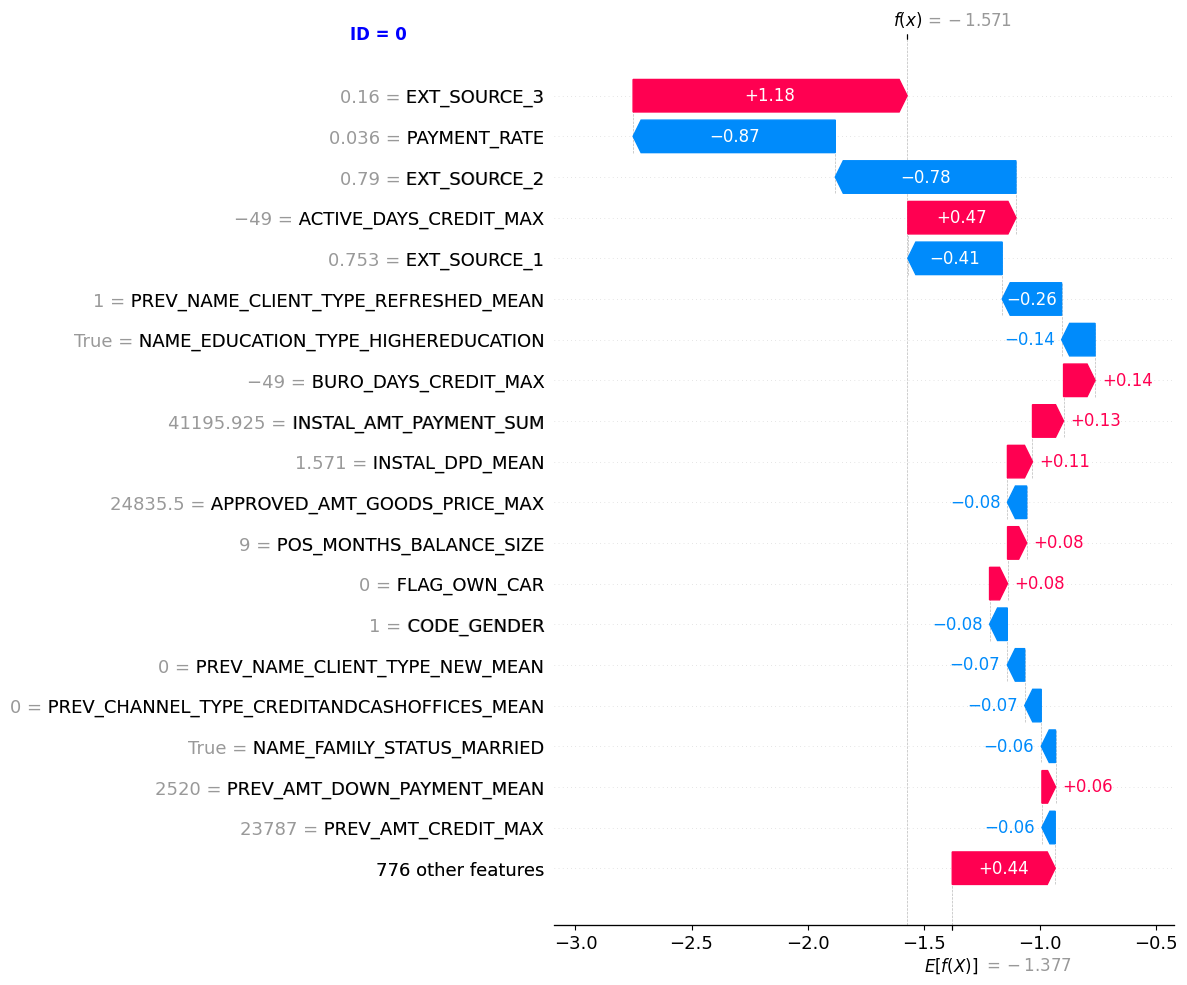

In [49]:
id_client = 0
fig=shap.waterfall_plot(exp[id_client],max_display=20,show=False)

title=plt.title('',loc='left')
title.set_position((-0.4,0))
title_text_obj = plt.text(-0.13,0.88, f"ID = {id_client}", color='blue', fontsize=12, fontweight='bold', transform=fig.transFigure)
plt.show(fig)


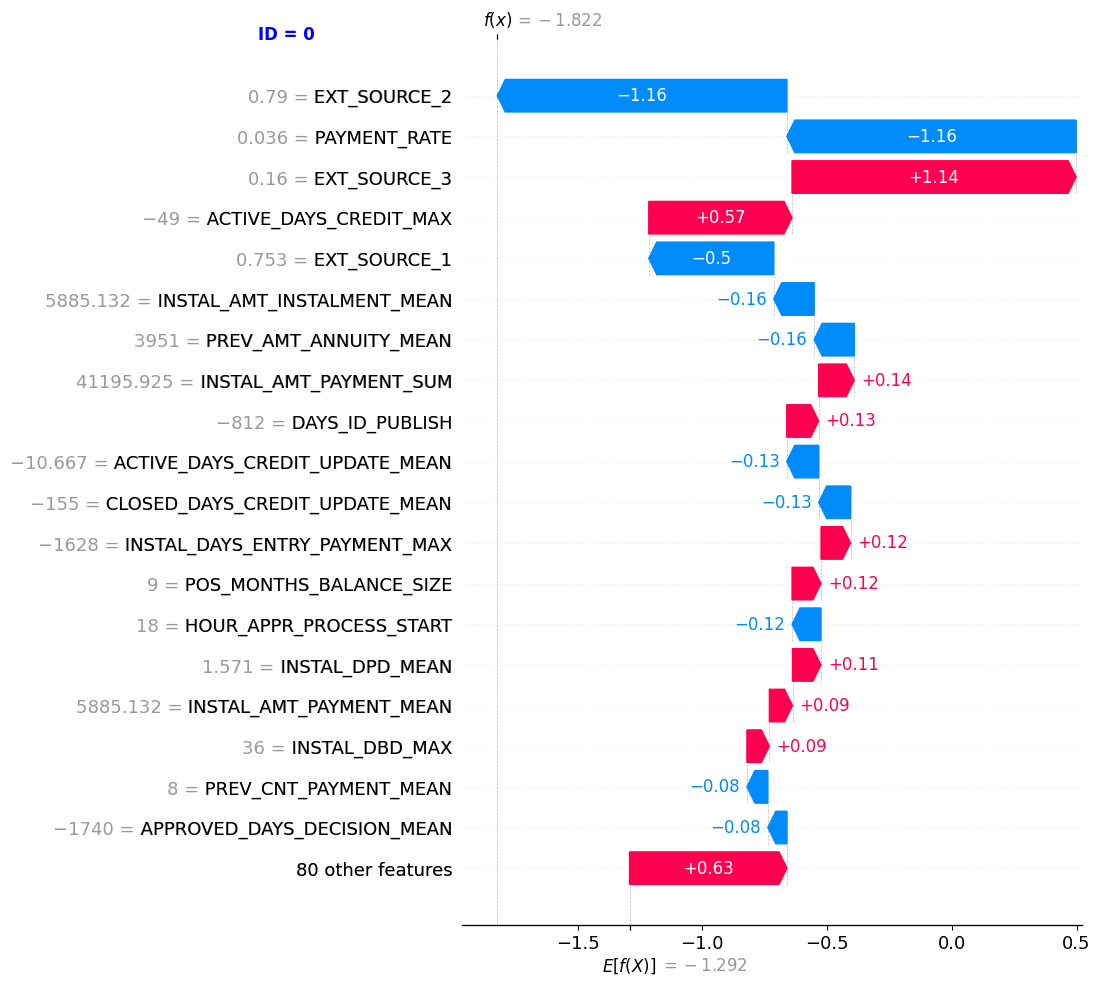

In [50]:
id_client = 0
fig=shap.waterfall_plot(exp_100[id_client],max_display=20,show=False)

title=plt.title('',loc='left')
title.set_position((-0.4,0))
title_text_obj = plt.text(-0.13,0.88, f"ID = {id_client}", color='blue', fontsize=12, fontweight='bold', transform=fig.transFigure)
plt.show(fig)

In [ ]:
exp[0][0]

In [ ]:
X.columns[inds[0:20]]

In [ ]:
inds[0:15]

In [ ]:
shap.initjs()
shap.plots.force(exp[0], matplotlib=True)

In [ ]:
[i for i in base_histo.columns if 'RATE' in i]

# Data Drift - Evidently

## chargement des bases au besoin

In [ ]:
base_histo=pd.read_csv("1_outputs/base_histo.csv",sep='\t',compression='gzip',index_col='ID')

In [ ]:
base_futur=pd.read_csv("1_outputs/base_futur.csv",sep='\t',compression='gzip',index_col='ID')

## Etablissement du rapport

In [ ]:
# Print the directories in sys.path
print("Directories in sys.path:")
for path in sys.path:
    print(path)

# Print the site-specific package directories
print("\nSite-specific package directories:")
for path in site.getsitepackages():
    print(path)

In [ ]:
base_histo.shape

In [ ]:
reference = base_histo[var_lgbm_100].drop(["TARGET","INDEX"],axis=1)
current = base_futur[var_lgbm_100].drop(["TARGET","INDEX"],axis=1)

In [ ]:
def clip_quart(col):
    return col.clip(upper=np.percentile(col.loc[col.isna()==False],75)+
                    10*(np.percentile(col.loc[col.isna()==False],75)-np.percentile(col.loc[col.isna()==False],25)),
                    lower=np.percentile(col.loc[col.isna()==False],25)-
                    10*(np.percentile(col.loc[col.isna()==False],75)-np.percentile(col.loc[col.isna()==False],25)))


reference.loc[:,reference.dtypes=='float64']=reference.loc[:,reference.dtypes=='float64'].apply(clip_quart,axis=0)
current.loc[:,current.dtypes=='float64']=current.loc[:,current.dtypes=='float64'].apply(clip_quart,axis=0)

In [ ]:
# 1 min 30 d'enregistrement
reference.to_csv("1_outputs/reference.csv",sep='\t',compression='gzip',index=True)
current.to_csv("1_outputs/current.csv",sep='\t',compression='gzip',index=True)

In [ ]:
# reference=pd.read_csv("1_outputs/base_histo.csv",sep='\t',compression='gzip',index_col='ID')
# current=pd.read_csv("1_outputs/base_futur.csv",sep='\t',compression='gzip',index_col='ID')

In [ ]:
reference_test=reference.sample(n=20000,axis=0,replace=False)
current_test=current.sample(n=20000,axis=0,replace=False)

In [ ]:
# mettre la distance hellinger sur AMT_INCOME_TOTAL car distribution possède outliers.
# sauf si clip_quartiles appliqué à la base => iso-méthode par rapport à la base utilisée pour les modèles
# 50 sec pour 10000 lignes et 100 colonnes
# 10-12 sec pour toutes les lignes sur 15 colonnes info_base
report = Report(metrics=[DataDriftPreset(drift_share=0.25)])
report.run(reference_data=reference_test, current_data=current_test)

In [ ]:
# report : 0 modif
# report_1 : modif drift_share
# report_2 : modif distance hellinger
# report_3 : modif clip valeurs extrêmes
# report_4 : sample 10k lignes, 100 var_lgbm, 1min 50 de calcul du rapport
# report_5 : sample 20k lignes, 100 var_lgbm, 3min 40 de calcul du rapport

report.save_html('1_outputs/report_5.html')